# **TEXT MINING PROJECT**: 20 NEWS GROUP CLASSIFICATION  

Antonella Zaccaria  
Marco Savino

Librerie utilizzate

In [1]:
import nltk
nltk.download('wordnet')
nltk.download('punkt') #serve per la tokenizzazione
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from sklearn.datasets import fetch_20newsgroups

import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score 

from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from wordcloud import WordCloud

Carichiamo il dataset 20 News Group direttamente dal **sklearn** e lo salviamo in formato csv

In [3]:
def twenty_newsgroup_to_csv():
    newsgroups = fetch_20newsgroups(subset = 'all', shuffle=True)

    df = pd.DataFrame([newsgroups.data, newsgroups.target.tolist()]).T
    df.columns = ['text', 'target']
    targets = pd.DataFrame(newsgroups.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out.to_csv('20_news.csv')
    
  
twenty_newsgroup_to_csv()

In [0]:
df = pd.read_csv('20_news.csv')

Visualizziamo le prime righe del dataset

In [5]:
df.head()

,Unnamed: 0,text,target,title
0,0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey
1,7,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey
2,8,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey
3,24,From: cs902043@ariel.yorku.ca (SHAWN LUDDINGTO...,10,rec.sport.hockey
4,44,From: gritter@cs.purdue.edu (Carl Gritter)\nSu...,10,rec.sport.hockey


Eliminiamo la colonna **Unnamed: 0**

In [0]:
df = df.drop('Unnamed: 0', 1)

In [7]:
df.head()

,text,target,title
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey
1,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey
2,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey
3,From: cs902043@ariel.yorku.ca (SHAWN LUDDINGTO...,10,rec.sport.hockey
4,From: gritter@cs.purdue.edu (Carl Gritter)\nSu...,10,rec.sport.hockey


## **Data exploration**

Esempio di news

In [8]:
print(df.text.loc[25])

From: golchowy@alchemy.chem.utoronto.ca (Gerald Olchowy)
Subject: Re: RUMOUR - Keenan signs with Rangers?
Organization: University of Toronto Chemistry Department
Lines: 22

In article <1993Apr16.171347.784@news.columbia.edu> gld@cunixb.cc.columbia.edu (Gary L Dare) writes:
>
>UPI Clarinet has just relayed a "scoop" from the Toronto Sun
>(or was that Star?  I like the Star myself ...) that Iron Mike
>Keenan has come to an agreement with the New York Rangers for
>next season.  Interestingly, this comes the day after the Times
>Sports had an editorial about how the Rangers need their own
>Pat Riley ... who cares about what happens after next season?
>

The rumour was basically everywhere in Toronto based on reports
that Keenan has told both San Jose and Philadelphia that he
was no longer interested in pursuing further negotiations with
either team. 

The Ranger announcement is supposed to happen tomorrow supposedly.

The Rangers have so many veterans that they had to get a coach
with "we

Controlliamo se sono presenti **na**

In [9]:
df.isnull().sum()

text      0
target    0
title     0
dtype: int64

Lista target

In [10]:
print(df.title.unique())

['rec.sport.hockey' 'comp.sys.ibm.pc.hardware' 'talk.politics.mideast'
 'comp.sys.mac.hardware' 'sci.electronics' 'talk.religion.misc'
 'sci.crypt' 'sci.med' 'alt.atheism' 'rec.motorcycles' 'rec.autos'
 'comp.windows.x' 'comp.graphics' 'sci.space' 'talk.politics.guns'
 'misc.forsale' 'rec.sport.baseball' 'talk.politics.misc'
 'comp.os.ms-windows.misc' 'soc.religion.christian']


In [11]:
print(df.target.unique())

[10  3 17  4 12 19 11 13  0  8  7  5  1 14 16  6  9 18  2 15]


Controlliamo se le categorie (target) sono bilanciate

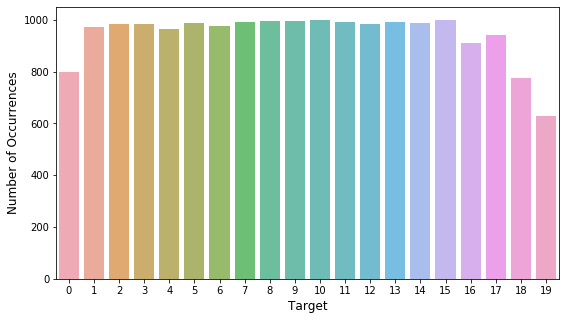

In [12]:
count_target = df['target'].value_counts()

plt.figure(figsize=(9,5))
sns.barplot(count_target.index, count_target.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target', fontsize=12);

## **Preprocessing**

Per le operazioni di preprocessing creiamo una nuova colonna del DataFrame df chiamata **text_processed**, mantenendo la colonna del testo originale

**1.** Conversione del testo in minuscolo

In [0]:
df['text_processed'] = df['text'].map(lambda x: x.lower())

**2.** Eliminazione indirizzi mail

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: re.sub('\S*@\S*\s?',' ', x))

**3.** Eliminazione numeri

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: re.sub('\d+',' ', x))

**4.** Eliminazione caratteri di punteggiatura

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: re.sub(r'[^\w]', ' ', x))

**5.** Rimozione parole composta da una e due lettere

In [0]:
df['text_processed'] = df['text_processed'].astype(str).map(lambda x: re.sub(r'\b\w{1,2}\b', '', x))

**6.** Sistemazione degli spazi che si sono creati con le precedenti operazioni

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: re.sub(' +', ' ', x))

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: x.lstrip()) #rimozione spazi di inizio riga

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: x.rstrip()) #rimozione spazi di fine riga

**7.** Tokenizzazione

In [0]:
df['text_processed'] = df['text_processed'].apply(lambda x: nltk.word_tokenize(x))

**8.** Rimozione Stopwords

In [0]:
#lista stop_words
en_stopwords = stopwords.words ('english')

In [23]:
#numero di stopwords
len(en_stopwords)

179

In [0]:
df['text_processed'] = df['text_processed'].apply(lambda x: [item for item in x if item not in en_stopwords])

Per effettuare le operazioni di lemmatizzazione e stemming verranno create quattro nuove colonne (rispettivamente **text_processed_lem**,  **text_processed_stem_porter**, **text_processed_stem_snowball** e **text_processed_stem_lancaster**) in modo da tenere separate le operazioni di lem e stem

**9.** Lemmatizzazione  

In [0]:
lemmatizer = WordNetLemmatizer()

In [0]:
df['text_processed_lem'] = df['text_processed'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

**10.** Stemming

**10.1** Porter Stemmer

In [0]:
ps = PorterStemmer()

In [0]:
df['text_processed_stem_porter'] = df['text_processed'].apply(lambda x: [ps.stem(y) for y in x])

**10.2** Snowball Stemmer

In [0]:
from nltk.stem.snowball import SnowballStemmer

In [0]:
ss = SnowballStemmer("english")

In [0]:
df['text_processed_stem_snowball'] = df['text_processed'].apply(lambda x: [ss.stem(y) for y in x])

**10.3** Lancaster Stemmer

In [0]:
from nltk.stem import LancasterStemmer

In [0]:
ls = LancasterStemmer()

In [0]:
df['text_processed_stem_lancaster'] = df['text_processed'].apply(lambda x: [ls.stem(y) for y in x])

Visualizziamo il **wordcloud** delle categorie 10 (rec.sport.hockey) e 19 (talk.religion.misc)

**rec.sport.hockey**

In [0]:
hockey = df[df.target == 10]

In [0]:
hockey2 = hockey.text_processed_lem.astype(str)

In [0]:
hockey3 = hockey2.str.replace("'", "")

In [0]:
wordcloud_hockey = WordCloud(width=800, height=800,background_color= 'white', max_words=120, stopwords=en_stopwords, ).generate(' '.join(hockey3))

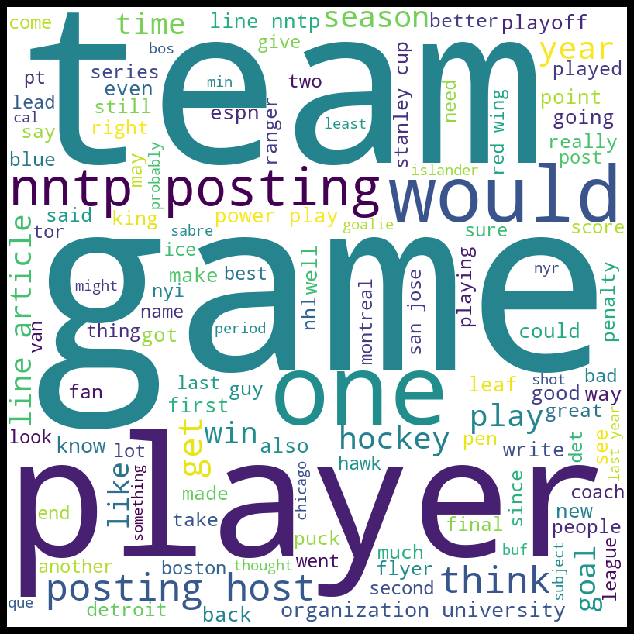

In [39]:
plt.figure(figsize = (10,10), facecolor='black')
plt.imshow(wordcloud_hockey)
plt.axis('off')
plt.tight_layout(pad=5)
plt.show()

**talk.religion.misc**

In [0]:
religion = df[df.target == 19]

In [0]:
religion2 = religion.text_processed_lem.astype(str)

In [0]:
religion3 = religion2.str.replace("'", "")

In [0]:
wordcloud_religion = WordCloud(width=800, height=800,background_color= 'white', max_words=120, stopwords=en_stopwords, ).generate(' '.join(religion3))

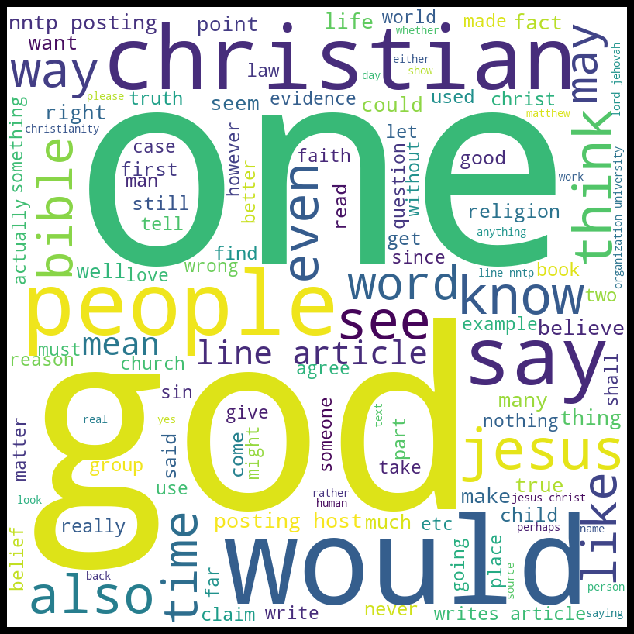

In [44]:
plt.figure(figsize = (10,10), facecolor='black')
plt.imshow(wordcloud_religion)
plt.axis('off')
plt.tight_layout(pad=5)
plt.show()

Teminata la fase di preprocessing del testo suddividiamo il Dataset in **train set (60%)** e **test set (40%)** in modo da poter addestrare e testare il classificatore  

**train_lem_x**: train set  di text_processed_lem  
**train_lem_y**: target train set di text_processed_lem  
**test_lem_x**: test set di text_processed_lem   
**test_lem_y**: target test di text_processed_lem 

**train_stem_porter_x**: train set  di text_processed_stem_porter  
**train_stem_porter_y**: target train set di text_processed_stem_porter    
**test_stem_porter_x**: test set di text_processed_stem_porter     
**test_stem_porter_y**: target test di text_processed_stem_porter  

**train_stem_snowball_x**: train set  di text_processed_stem_snowball  
**train_stem_porter_snowball_y**: target train set di text_processed_stem_snowball      
**test_stem_porter_snowball_x**: test set di text_processed_stem_snowball       
**test_stem_porter_snowball_y**: target test di text_processed_stem_snowball  

**train_stem_lancaster_x**: train set  di text_processed_stem_lancaster    
**train_stem_porter_lancaster_y**: target train set di text_processed_stem_lancaster        
**test_stem_porter_lancaster_x**: test set di text_processed_stem_lancaster         
**test_stem_porter_lancaster_y**: target test di text_processed_stem_lancaster  


In [0]:
train_lem_x, test_lem_x, train_lem_y, test_lem_y = model_selection.train_test_split(df['text_processed_lem'], df['target'], 
                                                                                    train_size= 0.6, test_size= 0.4, 
                                                                                    random_state = 123, shuffle = True)

In [0]:
train_stem_porter_x, test_stem_porter_x, train_stem_porter_y, test_stem_porter_y = model_selection.train_test_split(df['text_processed_stem_porter'], df['target'], 
                                                                                    train_size= 0.6, test_size= 0.4, 
                                                                                    random_state = 123, shuffle = True)

In [0]:
train_stem_snowball_x, test_stem_snowball_x, train_stem_snowball_y, test_stem_snowball_y = model_selection.train_test_split(df['text_processed_stem_snowball'], df['target'], 
                                                                                    train_size= 0.6, test_size= 0.4, 
                                                                                    random_state = 123, shuffle = True)

In [0]:
train_stem_lancaster_x, test_stem_lancaster_x, train_stem_lancaster_y, test_stem_lancaster_y = model_selection.train_test_split(df['text_processed_stem_lancaster'], df['target'], 
                                                                                    train_size= 0.6, test_size= 0.4, 
                                                                                    random_state = 123, shuffle = True)

In [49]:
print('La dimensione del train set dei dati "lemmatizzati" (train_lem_x) è', len(train_lem_x))
print('La dimensione del test set dei dati "lemmatizzati" (test_lem_x) è', len(test_lem_x))

print('La dimensione del train set dei dati "stemmatizzati (Porter)" (train_stem_porter_x) è', len(train_stem_porter_x))
print('La dimensione del test set dei dati "stemmatizzati (Porter)" (test_stem_porter_x) è', len(test_stem_porter_x))

print('La dimensione del train set dei dati "stemmatizzati (Snowball)" (train_stem_snowball_x) è', len(train_stem_snowball_x))
print('La dimensione del test set dei dati "stemmatizzati (Snowball)" (test_stem_snowball_x) è', len(test_stem_snowball_x))

print('La dimensione del train set dei dati "stemmatizzati (Lancaster)" (train_stem_lancaster_x) è', len(train_stem_lancaster_x))
print('La dimensione del test set dei dati "stemmatizzati (Lancaster)" (test_stem_lancaster_x) è', len(test_stem_lancaster_x))


La dimensione del train set dei dati "lemmatizzati" (train_lem_x) è 11307
La dimensione del test set dei dati "lemmatizzati" (test_lem_x) è 7539
La dimensione del train set dei dati "stemmatizzati (Porter)" (train_stem_porter_x) è 11307
La dimensione del test set dei dati "stemmatizzati (Porter)" (test_stem_porter_x) è 7539
La dimensione del train set dei dati "stemmatizzati (Snowball)" (train_stem_snowball_x) è 11307
La dimensione del test set dei dati "stemmatizzati (Snowball)" (test_stem_snowball_x) è 7539
La dimensione del train set dei dati "stemmatizzati (Lancaster)" (train_stem_lancaster_x) è 11307
La dimensione del test set dei dati "stemmatizzati (Lancaster)" (test_stem_lancaster_x) è 7539


## **Feature Engineering**  
In questa fase creiamo le strutture **tf** e **tf-idf** che saranno poi utilizzate dagli algoritmi di Machine Learning per effettuare la classificazione

**Term Frequency**

In [0]:
count_vect = CountVectorizer(analyzer='word')

I successivi otto passaggi servono per adeguare il formato alla funzione di creazione delle matrici tf e tf-idf

In [0]:
a = train_lem_x.astype(str)

In [0]:
b = test_lem_x.astype(str)

In [0]:
c = train_stem_porter_x.astype(str)

In [0]:
d = test_stem_porter_x.astype(str)

In [0]:
e = train_stem_snowball_x.astype(str)

In [0]:
f = test_stem_snowball_x.astype(str)

In [0]:
g = train_stem_lancaster_x.astype(str)

In [0]:
h = test_stem_lancaster_x.astype(str)

Creazione matrice tf per train_lem_x

In [59]:
tf_train_lem_x = count_vect.fit_transform(a)
tf_train_lem_x

<11307x73262 sparse matrix of type '<class 'numpy.int64'>'
	with 1128756 stored elements in Compressed Sparse Row format>

Creazione matrice tf per test_lem_x

In [60]:
tf_test_lem_x = count_vect.transform(b)
tf_test_lem_x

<7539x73262 sparse matrix of type '<class 'numpy.int64'>'
	with 729374 stored elements in Compressed Sparse Row format>

Creazione matrice tf per train_stem_porter_x

In [61]:
tf_train_stem_porter_x = count_vect.fit_transform(c)
tf_train_stem_porter_x

<11307x60398 sparse matrix of type '<class 'numpy.int64'>'
	with 1091121 stored elements in Compressed Sparse Row format>

Creazione matrice tf per test_stem_porter_x

In [62]:
tf_test_stem_porter_x = count_vect.transform(d)
tf_test_stem_porter_x

<7539x60398 sparse matrix of type '<class 'numpy.int64'>'
	with 708632 stored elements in Compressed Sparse Row format>

Creazione matrice tf per train_stem_snowball_x

In [63]:
tf_train_stem_snowball_x = count_vect.fit_transform(e)
tf_train_stem_snowball_x

<11307x60203 sparse matrix of type '<class 'numpy.int64'>'
	with 1090167 stored elements in Compressed Sparse Row format>

Creazione matrice tf per test_stem_snowball_x

In [64]:
tf_test_stem_snowball_x = count_vect.transform(f)
tf_test_stem_snowball_x

<7539x60203 sparse matrix of type '<class 'numpy.int64'>'
	with 708015 stored elements in Compressed Sparse Row format>

Creazione matrice tf per train_stem_lancaster_x

In [65]:
tf_train_stem_lancaster_x = count_vect.fit_transform(g)
tf_train_stem_lancaster_x

<11307x52122 sparse matrix of type '<class 'numpy.int64'>'
	with 1070250 stored elements in Compressed Sparse Row format>

Creazione matrice tf per test_stem_lancaster_x

In [66]:
tf_test_stem_lancaster_x = count_vect.transform(h)
tf_test_stem_lancaster_x

<7539x52122 sparse matrix of type '<class 'numpy.int64'>'
	with 697659 stored elements in Compressed Sparse Row format>

**TF-IDF unigram** 

In [0]:
tfidf = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1,1))

Creazione matrice tf-idf per train_lem_x

In [0]:
tfidf.fit(a)
tfidf_train_lem_x =  tfidf.transform(a)

In [69]:
tfidf_train_lem_x

<11307x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1046216 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per test_lem_x

In [0]:
tfidf_test_lem_x =  tfidf.transform(b)

In [71]:
tfidf_test_lem_x

<7539x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 689416 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per train_stem_porter_x

In [0]:
tfidf.fit(c)
tfidf_train_stem_porter_x =  tfidf.transform(c)

In [73]:
tfidf_train_stem_porter_x

<11307x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1036595 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per test_stem_porter_x

In [0]:
tfidf_test_stem_porter_x =  tfidf.transform(d)

In [75]:
tfidf_test_stem_porter_x

<7539x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 683884 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per train_stem_snowball_x

In [0]:
tfidf.fit(e)
tfidf_train_stem_snowball_x =  tfidf.transform(e)

In [77]:
tfidf_train_stem_snowball_x

<11307x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1036134 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per test_stem_snowball_x

In [0]:
tfidf_test_stem_snowball_x =  tfidf.transform(f)

In [79]:
tfidf_test_stem_snowball_x

<7539x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 683572 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per train_stem_lancaster_x

In [0]:
tfidf.fit(g)
tfidf_train_stem_lancaster_x =  tfidf.transform(g)

In [81]:
tfidf_train_stem_lancaster_x

<11307x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1030760 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per test_stem_lancaster_x

In [0]:
tfidf_test_stem_lancaster_x =  tfidf.transform(h)

In [83]:
tfidf_test_stem_lancaster_x

<7539x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 680760 stored elements in Compressed Sparse Row format>

**TF-IDF unigram + bigram** 

In [0]:
bi_tfidf = TfidfVectorizer(max_features=20000, analyzer='word',ngram_range=(1,2))

Creazione matrice tf-idf bigram per train_lem_x

In [0]:
bi_tfidf.fit(a)
bi_train_lem_x =  bi_tfidf.transform(a)

In [86]:
bi_train_lem_x

<11307x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1212679 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per test_lem_x

In [0]:
bi_test_lem_x =  bi_tfidf.transform(b)

In [88]:
bi_test_lem_x

<7539x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 795904 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per train_stem_porter_x

In [0]:
bi_tfidf.fit(c)
bi_train_stem_porter_x =  bi_tfidf.transform(c)

In [90]:
bi_train_stem_porter_x

<11307x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1233687 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per test_stem_porter_x

In [0]:
bi_test_stem_porter_x =  bi_tfidf.transform(d)

In [92]:
bi_test_stem_porter_x

<7539x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 809503 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per train_stem_snowball_x

In [0]:
bi_tfidf.fit(e)
bi_train_stem_snowball_x =  bi_tfidf.transform(e)

In [94]:
bi_train_stem_snowball_x

<11307x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1234101 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per test_stem_snowball_x

In [0]:
bi_test_stem_snowball_x =  bi_tfidf.transform(f)

In [96]:
bi_test_stem_snowball_x

<7539x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 809847 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per train_stem_lancaster_x

In [0]:
bi_tfidf.fit(g)
bi_train_stem_lancaster_x = bi_tfidf.transform(g)

In [98]:
bi_train_stem_lancaster_x

<11307x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1251220 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per test_stem_lancaster_x

In [0]:
bi_test_stem_lancaster_x = bi_tfidf.transform(h)

In [100]:
bi_test_stem_lancaster_x

<7539x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 820870 stored elements in Compressed Sparse Row format>

## **Classification**

### **1. Naive Bayes**

In [0]:
clf = MultinomialNB()

**1.1 Naive Bayes con TF + Lemmatization**

Cross Validation (train set)

In [102]:
%%time
score = cross_val_score(clf, tf_train_lem_x, train_lem_y, cv=5)

CPU times: user 373 ms, sys: 3.98 ms, total: 377 ms
Wall time: 383 ms


In [103]:
print(score)
print(score.mean())

[0.85720601 0.86295314 0.86687307 0.85935427 0.86333481]
0.8619442583678731


Previsione su dati mai visti (test set)

In [104]:
%%time
clf.fit(tf_train_lem_x, train_lem_y)
predicted = clf.predict(tf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       340
           1       0.70      0.88      0.78       374
           2       0.94      0.64      0.76       400
           3       0.74      0.80      0.77       393
           4       0.80      0.90      0.85       358
           5       0.81      0.88      0.84       416
           6       0.90      0.74      0.82       386
           7       0.89      0.92      0.90       396
           8       0.96      0.93      0.95       393
           9       0.97      0.94      0.96       405
          10       0.95      0.97      0.96       386
          11       0.90      0.96      0.93       400
          12       0.89      0.79      0.84       406
          13       0.95      0.95      0.95       380
          14       0.96      0.94      0.95       403
          15       0.86      0.94      0.89       391
          16       0.82      0.93      0.87       380
          17       0.96    

Confusion matrix

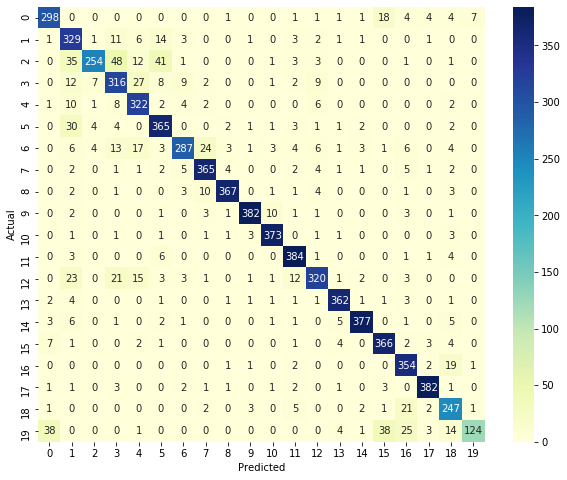

In [105]:
c_m = confusion_matrix(test_lem_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**1.2 Naive Bayes con TF + Stemming (Porter)**

Cross Validation (train set)

In [106]:
%%time
score = cross_val_score(clf, tf_train_stem_porter_x, train_stem_porter_y, cv=5)

CPU times: user 336 ms, sys: 3.94 ms, total: 340 ms
Wall time: 351 ms


In [107]:
print(score)
print(score.mean())

[0.85234306 0.85632184 0.86200796 0.84564352 0.85537373]
0.854338021680821


Previsione su dati mai visti (test set)

In [108]:
%%time
clf.fit(tf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       340
           1       0.70      0.87      0.77       374
           2       0.94      0.60      0.73       400
           3       0.72      0.79      0.75       393
           4       0.77      0.90      0.83       358
           5       0.83      0.87      0.85       416
           6       0.88      0.72      0.79       386
           7       0.89      0.92      0.90       396
           8       0.96      0.93      0.94       393
           9       0.97      0.95      0.96       405
          10       0.95      0.97      0.96       386
          11       0.87      0.96      0.91       400
          12       0.86      0.76      0.80       406
          13       0.95      0.94      0.95       380
          14       0.95      0.94      0.94       403
          15       0.85      0.94      0.89       391
          16       0.81      0.93      0.87       380
          17       0.95    

Confusion matrix

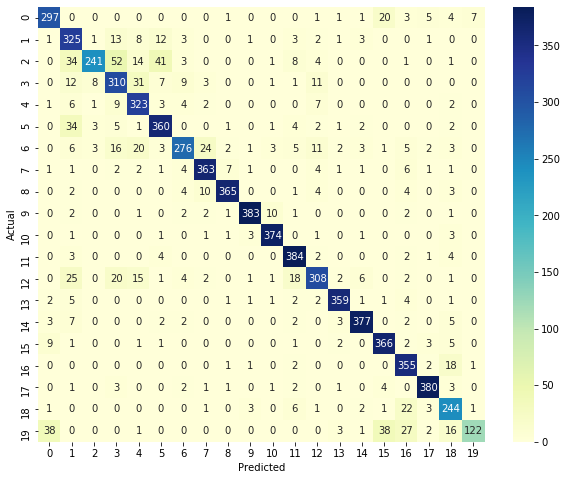

In [109]:
c_m = confusion_matrix(test_stem_porter_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**1.3 Naive Bayes con TF + Stemming (Snowball)**

Cross Validation (train set)

In [110]:
%%time
score = cross_val_score(clf, tf_train_stem_snowball_x, train_stem_snowball_y, cv=5)

CPU times: user 330 ms, sys: 6.03 ms, total: 336 ms
Wall time: 345 ms


In [111]:
print(score)
print(score.mean())

[0.85366932 0.85676393 0.8611234  0.8460858  0.85404688]
0.8543378652591848


Previsione su dati mai visti (test set)

In [112]:
%%time
clf.fit(tf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       340
           1       0.70      0.87      0.78       374
           2       0.94      0.60      0.73       400
           3       0.72      0.78      0.75       393
           4       0.77      0.90      0.83       358
           5       0.83      0.87      0.85       416
           6       0.89      0.72      0.79       386
           7       0.89      0.92      0.90       396
           8       0.96      0.93      0.94       393
           9       0.97      0.95      0.96       405
          10       0.95      0.97      0.96       386
          11       0.87      0.96      0.91       400
          12       0.86      0.74      0.80       406
          13       0.95      0.95      0.95       380
          14       0.94      0.93      0.94       403
          15       0.85      0.93      0.89       391
          16       0.81      0.93      0.87       380
          17       0.95    

Confusion matrix

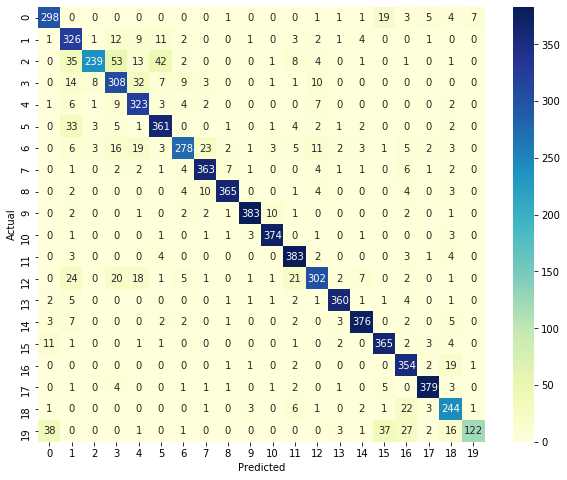

In [113]:
c_m = confusion_matrix(test_stem_snowball_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**1.4 Naive Bayes con TF + Stemming (Lancaster)**

Cross Validation (train set)

In [114]:
%%time
score = cross_val_score(clf, tf_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

CPU times: user 290 ms, sys: 4.92 ms, total: 295 ms
Wall time: 306 ms


In [115]:
print(score)
print(score.mean())

[0.8443855  0.85057471 0.8536046  0.83856701 0.84829721]
0.8470858062616362


Previsione su dati mai visti (test set)

In [116]:
%%time
clf.fit(tf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       340
           1       0.66      0.87      0.75       374
           2       0.93      0.55      0.69       400
           3       0.71      0.78      0.74       393
           4       0.79      0.89      0.84       358
           5       0.84      0.85      0.84       416
           6       0.88      0.70      0.78       386
           7       0.88      0.92      0.90       396
           8       0.95      0.93      0.94       393
           9       0.96      0.94      0.95       405
          10       0.95      0.97      0.96       386
          11       0.86      0.95      0.90       400
          12       0.83      0.74      0.79       406
          13       0.94      0.93      0.94       380
          14       0.94      0.92      0.93       403
          15       0.85      0.93      0.89       391
          16       0.81      0.92      0.86       380
          17       0.95    

Confusion matrix

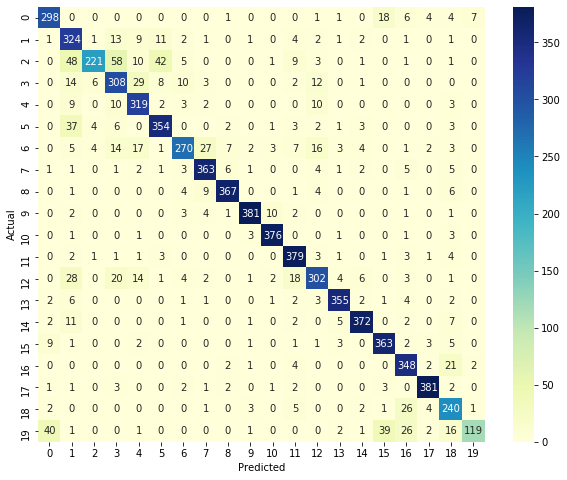

In [117]:
c_m = confusion_matrix(test_stem_lancaster_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**1.5 Naive Bayes con TF-IDF + Lemmatization**

Cross Validation (train set)

In [118]:
%%time
score = cross_val_score(clf, tfidf_train_lem_x, train_lem_y, cv=5)

CPU times: user 235 ms, sys: 3.97 ms, total: 238 ms
Wall time: 252 ms


In [119]:
print(score)
print(score.mean())

[0.84880637 0.86030062 0.86377709 0.85448916 0.8584697 ]
0.8571685885019932


Previsione su dati mai visti (test set)

In [120]:
%%time
clf.fit(tfidf_train_lem_x, train_lem_y)
predicted = clf.predict(tfidf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80       340
           1       0.76      0.86      0.81       374
           2       0.84      0.82      0.83       400
           3       0.75      0.80      0.77       393
           4       0.80      0.91      0.85       358
           5       0.92      0.86      0.89       416
           6       0.88      0.80      0.84       386
           7       0.90      0.92      0.91       396
           8       0.94      0.96      0.95       393
           9       0.96      0.95      0.96       405
          10       0.95      0.98      0.96       386
          11       0.88      0.97      0.92       400
          12       0.90      0.77      0.83       406
          13       0.94      0.93      0.93       380
          14       0.95      0.93      0.94       403
          15       0.67      0.96      0.79       391
          16       0.79      0.96      0.86       380
          17       0.95    

Confusion matrix

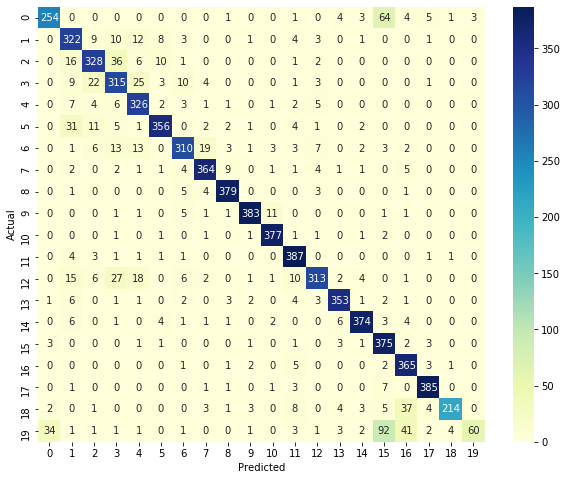

In [121]:
c_m = confusion_matrix(test_lem_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**1.6 Naive Bayes con TF-IDF + Stemming (Porter)**

Cross Validation (train set)

In [122]:
%%time
score = cross_val_score(clf, tfidf_train_stem_porter_x, train_stem_porter_y, cv=5)

CPU times: user 210 ms, sys: 3 ms, total: 213 ms
Wall time: 215 ms


In [123]:
print(score)
print(score.mean())

[0.84305924 0.85853227 0.85758514 0.84918178 0.85670057]
0.8530118008392804


Previsione su dati mai visti (test set)

In [124]:
%%time
clf.fit(tfidf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tfidf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.73      0.79       340
           1       0.76      0.86      0.81       374
           2       0.84      0.81      0.83       400
           3       0.75      0.80      0.77       393
           4       0.80      0.90      0.85       358
           5       0.93      0.85      0.89       416
           6       0.88      0.78      0.83       386
           7       0.90      0.92      0.91       396
           8       0.95      0.96      0.96       393
           9       0.96      0.94      0.95       405
          10       0.95      0.98      0.97       386
          11       0.84      0.97      0.90       400
          12       0.89      0.75      0.81       406
          13       0.94      0.93      0.94       380
          14       0.94      0.93      0.94       403
          15       0.66      0.96      0.78       391
          16       0.77      0.96      0.86       380
          17       0.95    

Confusion matrix

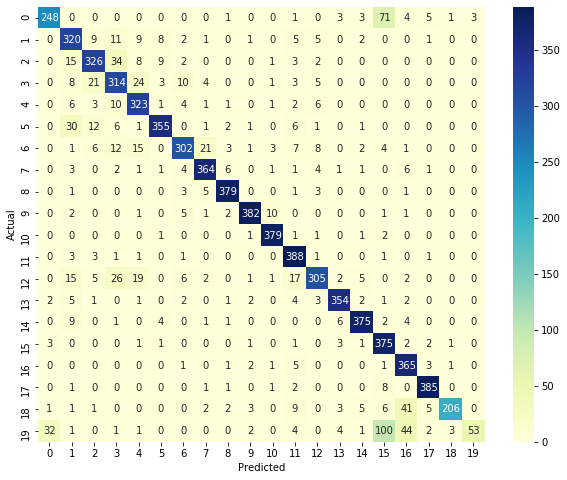

In [125]:
c_m = confusion_matrix(test_stem_porter_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**1.7 Naive Bayes con TF-IDF + Stemming (Snowball)**

Cross Validation (train set)

In [126]:
%%time
score = cross_val_score(clf, tfidf_train_stem_snowball_x, train_stem_snowball_y, cv=5)

CPU times: user 212 ms, sys: 1.94 ms, total: 214 ms
Wall time: 223 ms


In [127]:
print(score)
print(score.mean())

[0.84217507 0.85809019 0.85581601 0.85006634 0.85581601]
0.8523927231090678


Previsione su dati mai visti (test set)

In [128]:
%%time
clf.fit(tfidf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tfidf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.72      0.79       340
           1       0.76      0.86      0.81       374
           2       0.85      0.81      0.83       400
           3       0.75      0.80      0.77       393
           4       0.79      0.90      0.84       358
           5       0.93      0.85      0.89       416
           6       0.89      0.78      0.83       386
           7       0.90      0.92      0.91       396
           8       0.95      0.96      0.95       393
           9       0.96      0.94      0.95       405
          10       0.95      0.98      0.96       386
          11       0.84      0.97      0.90       400
          12       0.89      0.75      0.82       406
          13       0.94      0.93      0.94       380
          14       0.94      0.93      0.93       403
          15       0.66      0.96      0.78       391
          16       0.77      0.96      0.85       380
          17       0.95    

Confusion matrix

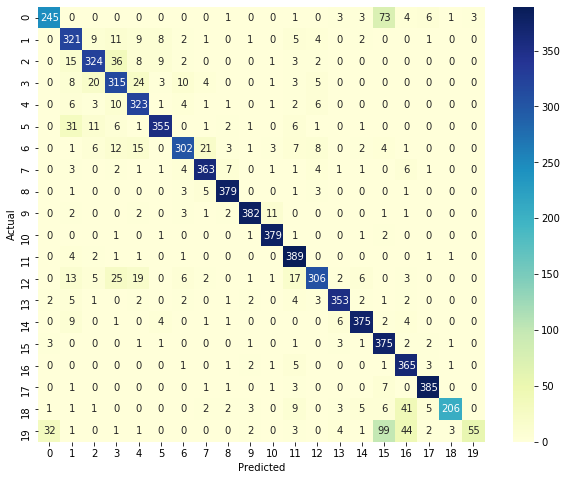

In [129]:
c_m = confusion_matrix(test_stem_snowball_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**1.8 Naive Bayes con TF-IDF + Stemming (Lancaster)**

Cross Validation (train set)

In [130]:
%%time
score = cross_val_score(clf, tfidf_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

CPU times: user 212 ms, sys: 964 µs, total: 213 ms
Wall time: 222 ms


In [131]:
print(score)
print(score.mean())

[0.83687003 0.85057471 0.85316232 0.8460858  0.83900929]
0.8451404294790651


Previsione su dati mai visti (test set)

In [132]:
%%time
clf.fit(tfidf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tfidf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.67      0.76       340
           1       0.77      0.86      0.81       374
           2       0.84      0.79      0.82       400
           3       0.71      0.79      0.75       393
           4       0.80      0.90      0.84       358
           5       0.94      0.84      0.89       416
           6       0.91      0.78      0.84       386
           7       0.89      0.92      0.91       396
           8       0.94      0.96      0.95       393
           9       0.97      0.95      0.96       405
          10       0.95      0.98      0.97       386
          11       0.84      0.97      0.90       400
          12       0.88      0.75      0.81       406
          13       0.94      0.91      0.92       380
          14       0.94      0.93      0.93       403
          15       0.62      0.96      0.75       391
          16       0.75      0.96      0.84       380
          17       0.96    

Confusion matrix

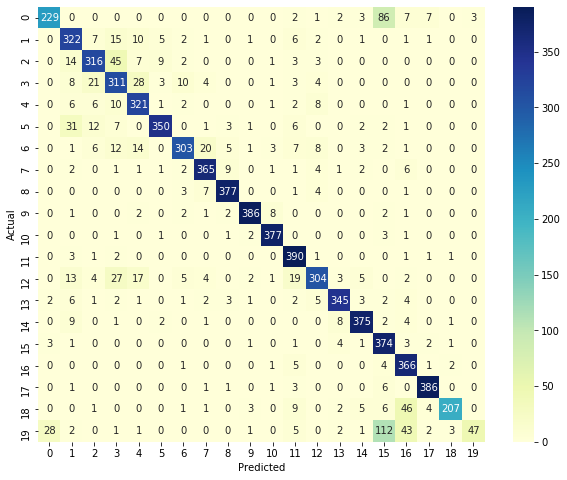

In [133]:
c_m = confusion_matrix(test_stem_lancaster_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**1.9 Naive Bayes con Bigram + Lemmatization**

Cross Validation (train set)

In [134]:
%%time
score = cross_val_score(clf, bi_train_lem_x, train_lem_y, cv=5)

CPU times: user 250 ms, sys: 945 µs, total: 251 ms
Wall time: 262 ms


In [135]:
print(score)
print(score.mean())

[0.85809019 0.86339523 0.86687307 0.85802742 0.8611234 ]
0.8615018588756177


Previsione su dati mai visti (test set)

In [136]:
%%time
clf.fit(bi_train_lem_x, train_lem_y)
predicted = clf.predict(bi_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       340
           1       0.74      0.87      0.80       374
           2       0.84      0.81      0.83       400
           3       0.76      0.79      0.77       393
           4       0.78      0.89      0.83       358
           5       0.91      0.87      0.89       416
           6       0.84      0.84      0.84       386
           7       0.90      0.90      0.90       396
           8       0.95      0.95      0.95       393
           9       0.96      0.93      0.95       405
          10       0.93      0.98      0.95       386
          11       0.94      0.95      0.95       400
          12       0.89      0.77      0.83       406
          13       0.93      0.93      0.93       380
          14       0.95      0.92      0.93       403
          15       0.71      0.95      0.81       391
          16       0.81      0.95      0.88       380
          17       0.95    

Confusion matrix

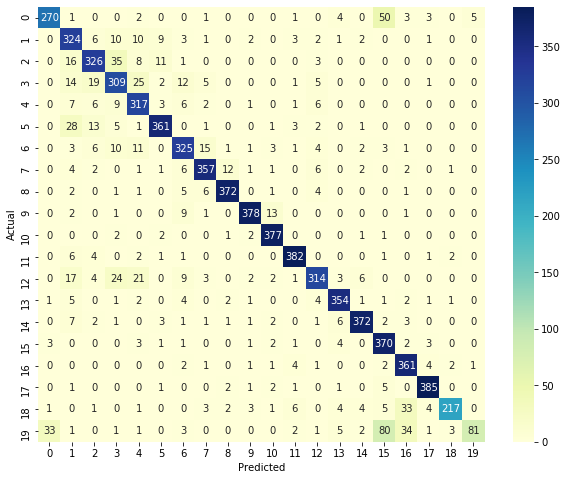

In [137]:
c_m = confusion_matrix(test_lem_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**1.10 Naive Bayes con Bigram + Stemming (Porter)**

Cross Validation (train set)

In [138]:
%%time
score = cross_val_score(clf, bi_train_stem_porter_x, train_stem_porter_y, cv=5)

CPU times: user 259 ms, sys: 2.99 ms, total: 262 ms
Wall time: 267 ms


In [139]:
print(score)
print(score.mean())

[0.85676393 0.86295314 0.86819991 0.8584697  0.86245024]
0.8617673846028708


Previsione su dati mai visti (test set)

In [140]:
%%time
clf.fit(bi_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(bi_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83       340
           1       0.74      0.85      0.79       374
           2       0.84      0.81      0.83       400
           3       0.75      0.78      0.77       393
           4       0.80      0.89      0.84       358
           5       0.90      0.88      0.89       416
           6       0.84      0.83      0.83       386
           7       0.90      0.91      0.90       396
           8       0.95      0.95      0.95       393
           9       0.95      0.94      0.95       405
          10       0.94      0.97      0.96       386
          11       0.93      0.96      0.94       400
          12       0.89      0.78      0.83       406
          13       0.92      0.93      0.92       380
          14       0.95      0.93      0.94       403
          15       0.71      0.96      0.82       391
          16       0.81      0.95      0.87       380
          17       0.95    

Confusion matrix

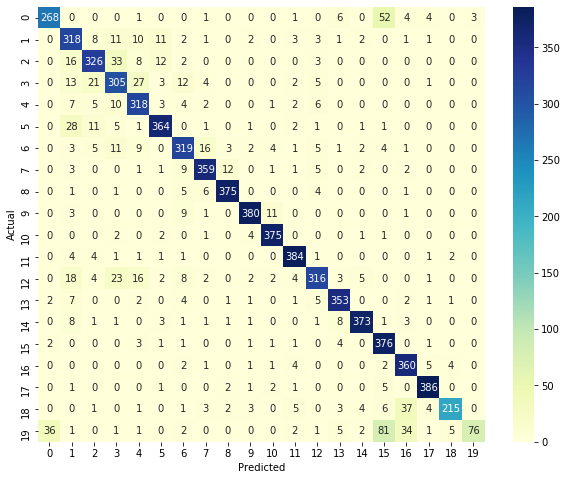

In [141]:
c_m = confusion_matrix(test_stem_porter_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**1.11 Naive Bayes con Bigram + Stemming (Snowball)**

Cross Validation (train set)

In [142]:
%%time
score = cross_val_score(clf, bi_train_stem_snowball_x, train_stem_snowball_y, cv=5)

CPU times: user 256 ms, sys: 3.03 ms, total: 259 ms
Wall time: 261 ms


In [143]:
print(score)
print(score.mean())

[0.85632184 0.86383731 0.86952676 0.85802742 0.86156568]
0.8618558019326675


Previsione su dati mai visti (test set)

In [144]:
%%time
clf.fit(bi_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(bi_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       340
           1       0.73      0.86      0.79       374
           2       0.85      0.81      0.83       400
           3       0.76      0.77      0.77       393
           4       0.80      0.90      0.85       358
           5       0.90      0.89      0.89       416
           6       0.84      0.83      0.83       386
           7       0.90      0.90      0.90       396
           8       0.95      0.95      0.95       393
           9       0.95      0.94      0.95       405
          10       0.94      0.97      0.96       386
          11       0.93      0.96      0.95       400
          12       0.89      0.79      0.84       406
          13       0.92      0.93      0.93       380
          14       0.95      0.93      0.94       403
          15       0.71      0.96      0.81       391
          16       0.81      0.95      0.87       380
          17       0.95    

Confusion matrix

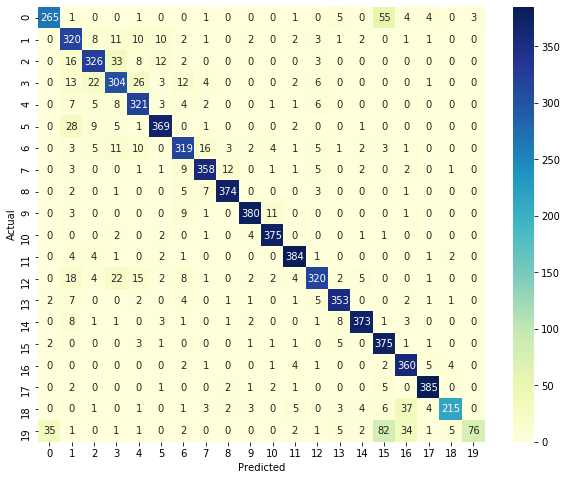

In [145]:
c_m = confusion_matrix(test_stem_snowball_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**1.12 Naive Bayes con Bigram + Stemming (Lancaster)**

Cross Validation (train set)

In [146]:
%%time
score = cross_val_score(clf, bi_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

CPU times: user 244 ms, sys: 1.97 ms, total: 246 ms
Wall time: 247 ms


In [147]:
print(score)
print(score.mean())

[0.85676393 0.86030062 0.8659885  0.85581601 0.85493145]
0.8587601004383325


Previsione su dati mai visti (test set)

In [148]:
%%time
clf.fit(bi_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(bi_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81       340
           1       0.72      0.85      0.78       374
           2       0.85      0.79      0.82       400
           3       0.73      0.78      0.75       393
           4       0.78      0.89      0.83       358
           5       0.90      0.87      0.89       416
           6       0.85      0.83      0.84       386
           7       0.89      0.91      0.90       396
           8       0.94      0.95      0.95       393
           9       0.95      0.93      0.94       405
          10       0.95      0.97      0.96       386
          11       0.94      0.95      0.94       400
          12       0.89      0.78      0.83       406
          13       0.92      0.91      0.91       380
          14       0.94      0.93      0.93       403
          15       0.69      0.95      0.80       391
          16       0.81      0.95      0.88       380
          17       0.96    

Confusion matrix

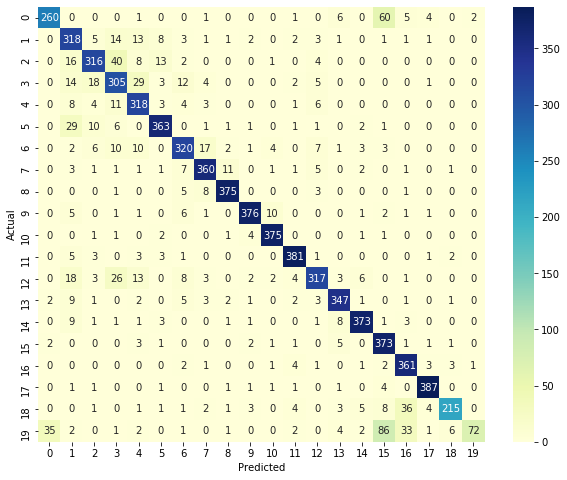

In [149]:
c_m = confusion_matrix(test_stem_lancaster_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### **2. Support Vector Machine (SVM)**

In [0]:
clf = svm.SVC()

**2.1 SVM con TF + Lemmatization**

Cross Validation (train set)

In [152]:
%%time
score = cross_val_score(clf, tf_train_lem_x, train_lem_y, cv=5)

CPU times: user 9min 9s, sys: 77.1 ms, total: 9min 10s
Wall time: 9min 10s


In [153]:
print(score)
print(score.mean())

[0.75862069 0.74005305 0.75497567 0.74834144 0.75984078]
0.7523663269579786


Previsione su dati mai visti (test set)

In [154]:
%%time
clf.fit(tf_train_lem_x, train_lem_y)
predicted = clf.predict(tf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.85      0.69      0.76       340
           1       0.43      0.85      0.57       374
           2       0.81      0.64      0.71       400
           3       0.77      0.65      0.70       393
           4       0.84      0.81      0.82       358
           5       0.87      0.72      0.79       416
           6       0.63      0.87      0.73       386
           7       0.88      0.82      0.85       396
           8       0.93      0.87      0.90       393
           9       0.88      0.89      0.89       405
          10       0.98      0.84      0.91       386
          11       0.98      0.84      0.90       400
          12       0.60      0.80      0.68       406
          13       0.82      0.81      0.81       380
          14       0.96      0.78      0.86       403
          15       0.81      0.87      0.84       391
          16       0.86      0.78      0.81       380
          17       0.71    

Confusion matrix

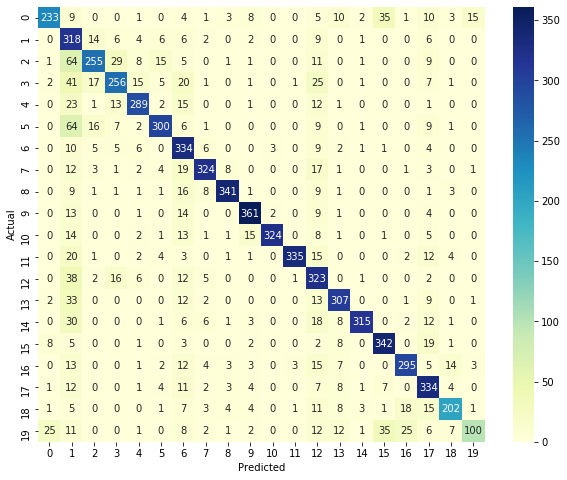

In [155]:
c_m = confusion_matrix(test_lem_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**2.2 SVM con TF + Stemming (Porter)**

Cross validation (train set)

In [156]:
%%time
score = cross_val_score(clf, tf_train_stem_porter_x, train_stem_porter_y, cv=5)

CPU times: user 8min 52s, sys: 90 ms, total: 8min 52s
Wall time: 8min 52s


In [157]:
print(score)
print(score.mean())

[0.75243148 0.744916   0.75143742 0.74214949 0.75851393]
0.749889664088447


Previsione su dati mai visti (test set)

In [158]:
%%time
clf.fit(tf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.81      0.71      0.76       340
           1       0.45      0.84      0.59       374
           2       0.79      0.63      0.70       400
           3       0.76      0.68      0.72       393
           4       0.86      0.77      0.82       358
           5       0.87      0.72      0.79       416
           6       0.59      0.88      0.71       386
           7       0.87      0.82      0.84       396
           8       0.94      0.87      0.90       393
           9       0.88      0.90      0.89       405
          10       0.98      0.85      0.91       386
          11       0.98      0.84      0.90       400
          12       0.63      0.79      0.70       406
          13       0.80      0.82      0.81       380
          14       0.96      0.79      0.87       403
          15       0.82      0.85      0.84       391
          16       0.84      0.78      0.81       380
          17       0.70    

Confusion matrix

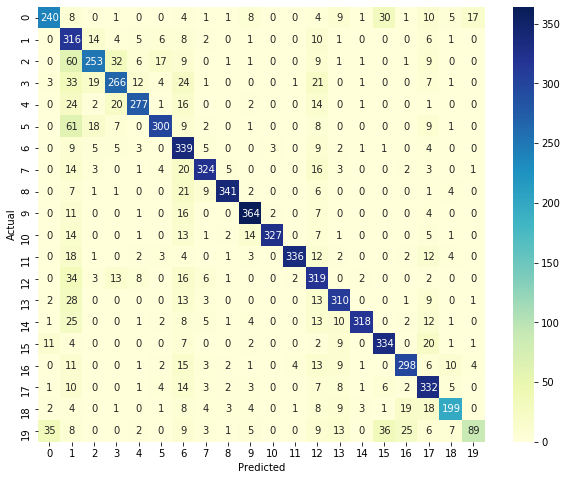

In [159]:
c_m = confusion_matrix(test_stem_porter_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**2.3 SVM con TF + Stemming (Snowball)**

Cross Validation (train set)

In [160]:
%%time
score = cross_val_score(clf, tf_train_stem_snowball_x, train_stem_snowball_y, cv=5)

CPU times: user 8min 54s, sys: 75.7 ms, total: 8min 54s
Wall time: 8min 55s


In [161]:
print(score)
print(score.mean())

[0.75198939 0.74314766 0.75143742 0.74082264 0.75851393]
0.749182208133847


Previsione su dati mai visti (test set)

In [162]:
%%time
clf.fit(tf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76       340
           1       0.45      0.84      0.59       374
           2       0.79      0.64      0.71       400
           3       0.76      0.68      0.72       393
           4       0.86      0.77      0.81       358
           5       0.88      0.72      0.79       416
           6       0.59      0.88      0.71       386
           7       0.87      0.82      0.85       396
           8       0.95      0.87      0.90       393
           9       0.88      0.89      0.89       405
          10       0.98      0.85      0.91       386
          11       0.98      0.84      0.90       400
          12       0.64      0.79      0.70       406
          13       0.80      0.82      0.81       380
          14       0.97      0.79      0.87       403
          15       0.82      0.85      0.84       391
          16       0.85      0.78      0.81       380
          17       0.70    

Confusion matrix

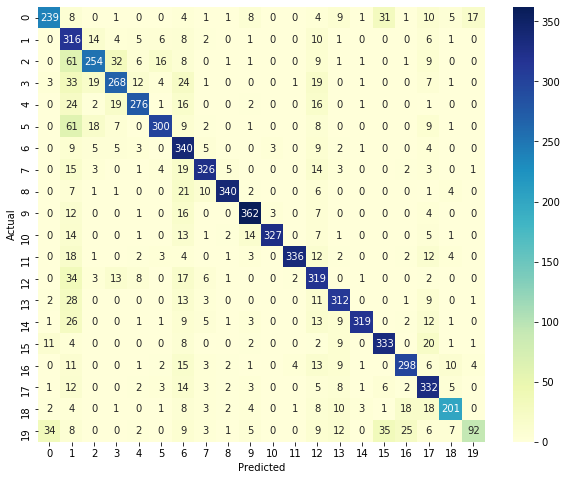

In [163]:
c_m = confusion_matrix(test_stem_snowball_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**2.4 SVM con TF + Stemming (Lancaster)**

Cross Validation (train set)

In [164]:
%%time
score = cross_val_score(clf, tf_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

CPU times: user 8min 37s, sys: 63 ms, total: 8min 37s
Wall time: 8min 37s


In [165]:
print(score)
print(score.mean())

[0.74668435 0.73209549 0.74657231 0.74657231 0.75011057]
0.7444070075328749


Previsione su dati mai visti (test set)

In [166]:
%%time
clf.fit(tf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.82      0.69      0.75       340
           1       0.45      0.83      0.59       374
           2       0.79      0.58      0.67       400
           3       0.72      0.68      0.70       393
           4       0.82      0.80      0.81       358
           5       0.83      0.72      0.77       416
           6       0.57      0.87      0.69       386
           7       0.83      0.80      0.82       396
           8       0.94      0.87      0.90       393
           9       0.89      0.87      0.88       405
          10       0.98      0.85      0.91       386
          11       0.98      0.81      0.89       400
          12       0.63      0.77      0.69       406
          13       0.82      0.81      0.81       380
          14       0.96      0.78      0.86       403
          15       0.80      0.85      0.82       391
          16       0.84      0.79      0.82       380
          17       0.70    

Confusion matrix

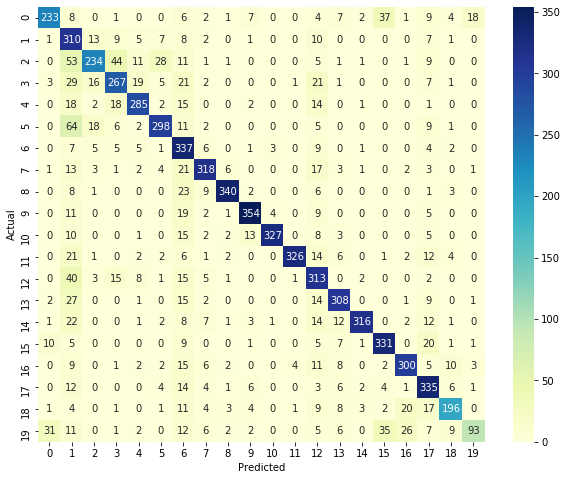

In [167]:
c_m = confusion_matrix(test_stem_lancaster_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**2.5 SVM con TF-IDF + Lemmatization**

Cross Validation (train set)

In [168]:
%%time
score = cross_val_score(clf, tfidf_train_lem_x, train_lem_y, cv=5)

CPU times: user 12min 39s, sys: 78.9 ms, total: 12min 39s
Wall time: 12min 40s


In [169]:
print(score)
print(score.mean())

[0.88549956 0.88240495 0.89208315 0.88191066 0.88677576]
0.8857348160540217


Previsione su dati mai visti (test set)

In [170]:
%%time
clf.fit(tfidf_train_lem_x, train_lem_y)
predicted = clf.predict(tfidf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       340
           1       0.75      0.91      0.82       374
           2       0.85      0.83      0.84       400
           3       0.79      0.81      0.80       393
           4       0.92      0.87      0.89       358
           5       0.90      0.89      0.89       416
           6       0.85      0.87      0.86       386
           7       0.93      0.92      0.92       396
           8       0.98      0.95      0.96       393
           9       0.96      0.97      0.96       405
          10       0.98      0.96      0.97       386
          11       0.99      0.92      0.95       400
          12       0.82      0.89      0.86       406
          13       0.91      0.95      0.93       380
          14       0.98      0.93      0.95       403
          15       0.87      0.94      0.90       391
          16       0.90      0.92      0.91       380
          17       0.99    

Confusion matrix

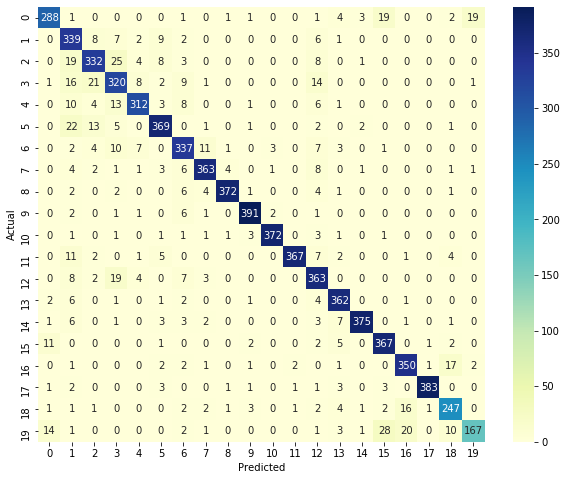

In [171]:
c_m = confusion_matrix(test_lem_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**2.6 SVM con TF-IDF + Stemming (Porter)**

Cross Validation (train set)

In [172]:
%%time
score = cross_val_score(clf, tfidf_train_stem_porter_x, train_stem_porter_y, cv=5)

CPU times: user 12min 39s, sys: 82.1 ms, total: 12min 39s
Wall time: 12min 40s


In [173]:
print(score)
print(score.mean())

[0.88373121 0.88284704 0.89739054 0.8783724  0.88898717]
0.8862656719814828


Previsione su dati mai visti (test set)

In [174]:
%%time
clf.fit(tfidf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tfidf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       340
           1       0.73      0.91      0.81       374
           2       0.86      0.83      0.84       400
           3       0.80      0.81      0.81       393
           4       0.91      0.87      0.89       358
           5       0.89      0.89      0.89       416
           6       0.85      0.87      0.86       386
           7       0.93      0.92      0.92       396
           8       0.98      0.96      0.97       393
           9       0.98      0.97      0.97       405
          10       0.99      0.97      0.98       386
          11       0.99      0.92      0.95       400
          12       0.82      0.90      0.86       406
          13       0.91      0.95      0.93       380
          14       0.98      0.93      0.96       403
          15       0.88      0.94      0.91       391
          16       0.90      0.91      0.91       380
          17       0.99    

Confusion matrix

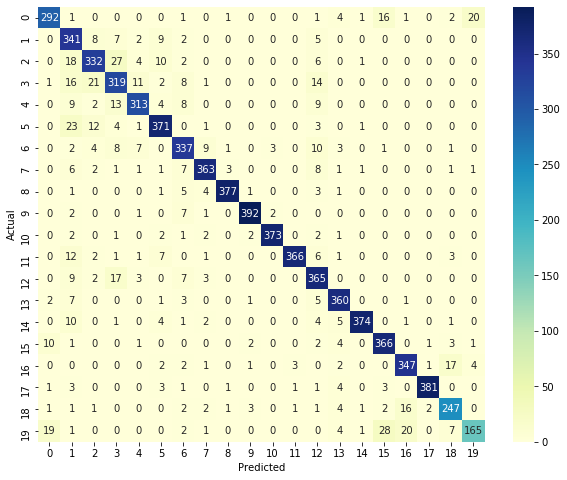

In [175]:
c_m = confusion_matrix(test_stem_porter_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**2.7 SVM con TF-IDF + Stemming (Snowball)**

Cross Validation (train set)

In [176]:
%%time
score = cross_val_score(clf, tfidf_train_stem_snowball_x, train_stem_snowball_y, cv=5)

CPU times: user 12min 26s, sys: 66.1 ms, total: 12min 26s
Wall time: 12min 27s


In [177]:
print(score)
print(score.mean())

[0.88505747 0.88152078 0.89694825 0.87881468 0.89031402]
0.8865310412870997


Previsione su dati mai visti (test set)

In [178]:
%%time
clf.fit(tfidf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tfidf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       340
           1       0.74      0.91      0.82       374
           2       0.86      0.83      0.84       400
           3       0.80      0.81      0.81       393
           4       0.90      0.87      0.89       358
           5       0.88      0.89      0.89       416
           6       0.85      0.87      0.86       386
           7       0.93      0.91      0.92       396
           8       0.99      0.96      0.97       393
           9       0.98      0.97      0.97       405
          10       0.99      0.97      0.98       386
          11       0.99      0.92      0.95       400
          12       0.82      0.90      0.86       406
          13       0.91      0.95      0.93       380
          14       0.98      0.93      0.96       403
          15       0.88      0.94      0.91       391
          16       0.90      0.91      0.90       380
          17       0.99    

Confusion matrix

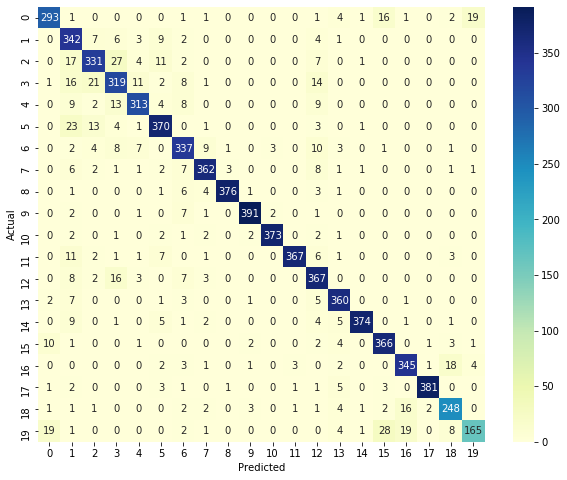

In [179]:
c_m = confusion_matrix(test_stem_snowball_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**2.8 SVM con TF-IDF + Stemming (Lancaster)**

Cross Validation (train set)

In [180]:
%%time
score = cross_val_score(clf, tfidf_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

CPU times: user 12min 25s, sys: 77 ms, total: 12min 25s
Wall time: 12min 26s


In [181]:
print(score)
print(score.mean())

[0.87842617 0.88284704 0.88810261 0.8783724  0.88810261]
0.883170166014193


Previsione su dati mai visti (test set)

In [182]:
%%time
clf.fit(tfidf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tfidf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       340
           1       0.73      0.90      0.81       374
           2       0.86      0.80      0.83       400
           3       0.77      0.82      0.79       393
           4       0.91      0.87      0.89       358
           5       0.86      0.89      0.87       416
           6       0.86      0.87      0.87       386
           7       0.90      0.90      0.90       396
           8       0.98      0.95      0.97       393
           9       0.96      0.96      0.96       405
          10       0.98      0.97      0.98       386
          11       0.99      0.91      0.95       400
          12       0.81      0.88      0.85       406
          13       0.89      0.93      0.91       380
          14       0.96      0.93      0.95       403
          15       0.89      0.93      0.91       391
          16       0.89      0.91      0.90       380
          17       0.99    

Confusion matrix

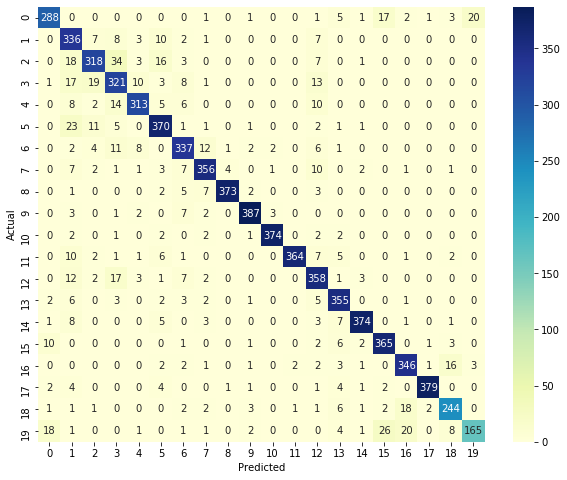

In [183]:
c_m = confusion_matrix(test_stem_lancaster_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**2.9 SVM con Bigram + Lemmatization**

Cross Validation (train set)

In [184]:
%%time
score = cross_val_score(clf, bi_train_lem_x, train_lem_y, cv=5)

CPU times: user 14min 11s, sys: 86 ms, total: 14min 11s
Wall time: 14min 12s


In [185]:
print(score)
print(score.mean())

[0.88859416 0.88373121 0.89473684 0.88810261 0.88677576]
0.8883881180561014


Previsione su dati mai visti (test set)

In [186]:
%%time
clf.fit(bi_train_lem_x, train_lem_y)
predicted = clf.predict(bi_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       340
           1       0.71      0.90      0.80       374
           2       0.86      0.82      0.84       400
           3       0.79      0.80      0.79       393
           4       0.89      0.88      0.89       358
           5       0.91      0.88      0.90       416
           6       0.85      0.88      0.87       386
           7       0.92      0.89      0.91       396
           8       0.97      0.95      0.96       393
           9       0.97      0.96      0.96       405
          10       0.99      0.96      0.97       386
          11       0.99      0.92      0.96       400
          12       0.81      0.89      0.85       406
          13       0.90      0.95      0.92       380
          14       0.98      0.93      0.95       403
          15       0.89      0.94      0.91       391
          16       0.91      0.92      0.91       380
          17       0.99    

Confusion matrix

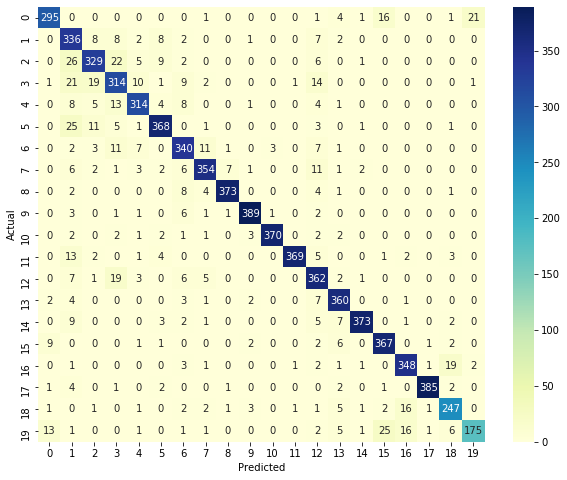

In [187]:
c_m = confusion_matrix(test_lem_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**2.10 SVM con Bigram + Stemming (Porter)**

Cross Validation (train set)

In [188]:
%%time
score = cross_val_score(clf, bi_train_stem_porter_x, train_stem_porter_y, cv=5)

CPU times: user 14min 33s, sys: 85.1 ms, total: 14min 33s
Wall time: 14min 34s


In [189]:
print(score)
print(score.mean())

[0.88461538 0.88373121 0.89606369 0.88766033 0.88721805]
0.8878577313935485


Previsione su dati mai visti (test set)

In [190]:
%%time
clf.fit(bi_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(bi_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89       340
           1       0.71      0.90      0.79       374
           2       0.86      0.82      0.84       400
           3       0.79      0.79      0.79       393
           4       0.90      0.88      0.89       358
           5       0.90      0.88      0.89       416
           6       0.84      0.88      0.86       386
           7       0.92      0.91      0.91       396
           8       0.99      0.96      0.97       393
           9       0.97      0.96      0.97       405
          10       0.99      0.96      0.97       386
          11       0.99      0.93      0.96       400
          12       0.82      0.89      0.85       406
          13       0.91      0.94      0.93       380
          14       0.98      0.93      0.95       403
          15       0.89      0.94      0.91       391
          16       0.91      0.92      0.91       380
          17       0.99    

Confusion matrix

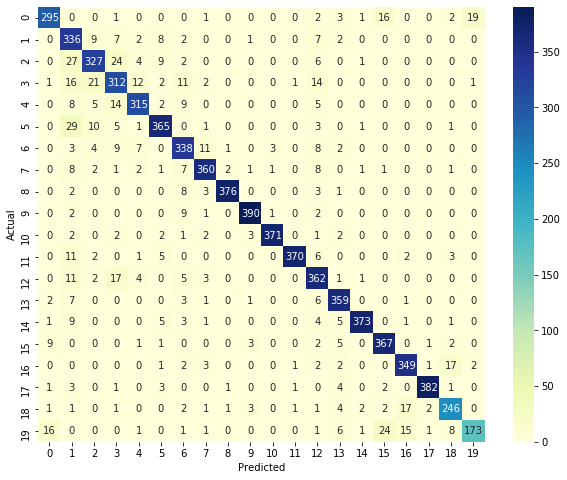

In [191]:
c_m = confusion_matrix(test_stem_porter_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**2.11 SVM con Bigram + Stemming (Snowball)**

Cross Validation (train set)

In [192]:
%%time
score = cross_val_score(clf, bi_train_stem_snowball_x, train_stem_snowball_y, cv=5)

CPU times: user 14min 4s, sys: 62.1 ms, total: 14min 5s
Wall time: 14min 5s


In [193]:
print(score)
print(score.mean())

[0.88549956 0.8841733  0.89694825 0.88633348 0.88677576]
0.8879460705125272


Previsione su dati mai visti (test set)

In [194]:
%%time
clf.fit(bi_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(bi_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       340
           1       0.71      0.90      0.79       374
           2       0.86      0.82      0.84       400
           3       0.79      0.80      0.79       393
           4       0.90      0.88      0.89       358
           5       0.90      0.88      0.89       416
           6       0.84      0.88      0.86       386
           7       0.92      0.90      0.91       396
           8       0.99      0.96      0.97       393
           9       0.97      0.96      0.97       405
          10       0.99      0.96      0.97       386
          11       0.99      0.92      0.95       400
          12       0.81      0.89      0.85       406
          13       0.91      0.94      0.92       380
          14       0.98      0.93      0.95       403
          15       0.89      0.94      0.91       391
          16       0.91      0.92      0.92       380
          17       0.99    

Confusion matrix

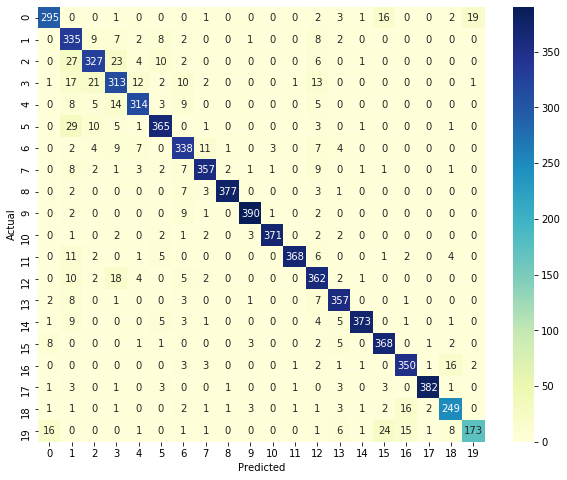

In [195]:
c_m = confusion_matrix(test_stem_snowball_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "YlGnBu", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**2.12 SVM con Bigram + Stemming (Lancaster)**

Cross Validation (train set)

In [196]:
%%time
score = cross_val_score(clf, bi_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

CPU times: user 13min 44s, sys: 66.1 ms, total: 13min 44s
Wall time: 13min 44s


In [197]:
print(score)
print(score.mean())

[0.88328912 0.88505747 0.89473684 0.88677576 0.88677576]
0.8873269927823146


Previsione su dati mai visti (test set)

In [198]:
%%time
clf.fit(bi_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(bi_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       340
           1       0.72      0.89      0.80       374
           2       0.87      0.80      0.84       400
           3       0.76      0.80      0.78       393
           4       0.89      0.87      0.88       358
           5       0.90      0.89      0.89       416
           6       0.84      0.88      0.86       386
           7       0.90      0.90      0.90       396
           8       0.98      0.95      0.96       393
           9       0.96      0.96      0.96       405
          10       0.98      0.96      0.97       386
          11       0.99      0.92      0.95       400
          12       0.82      0.90      0.86       406
          13       0.90      0.92      0.91       380
          14       0.98      0.92      0.95       403
          15       0.90      0.94      0.92       391
          16       0.90      0.92      0.91       380
          17       0.99    

Confusion matrix

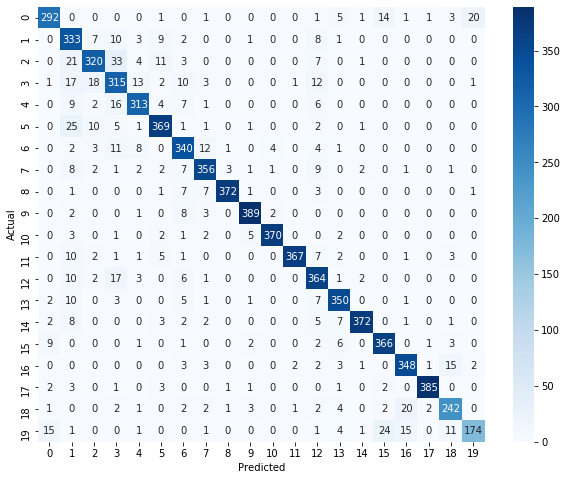

In [199]:
c_m = confusion_matrix(test_stem_lancaster_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

###**3. Random Forest**

In [0]:
clf = RandomForestClassifier()

**3.1 Random Forest con TF + Lemmatization**

Cross Validation (train test)

In [202]:
%%time
score = cross_val_score(clf, tf_train_lem_x, train_lem_y, cv=5)

CPU times: user 2min 45s, sys: 188 ms, total: 2min 45s
Wall time: 2min 46s


In [203]:
print(score)
print(score.mean())

[0.82714412 0.81432361 0.83856701 0.83060593 0.8288368 ]
0.8278954915764993


Previsione su dati mai visti (test set)

In [204]:
%%time
clf.fit(tf_train_lem_x, train_lem_y)
predicted = clf.predict(tf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       340
           1       0.67      0.76      0.71       374
           2       0.74      0.85      0.79       400
           3       0.73      0.72      0.72       393
           4       0.80      0.85      0.82       358
           5       0.86      0.80      0.83       416
           6       0.76      0.89      0.82       386
           7       0.88      0.84      0.86       396
           8       0.93      0.92      0.92       393
           9       0.89      0.93      0.91       405
          10       0.93      0.96      0.95       386
          11       0.95      0.93      0.94       400
          12       0.88      0.71      0.78       406
          13       0.89      0.87      0.88       380
          14       0.90      0.90      0.90       403
          15       0.75      0.94      0.83       391
          16       0.79      0.89      0.84       380
          17       0.96    

Confusion matrix

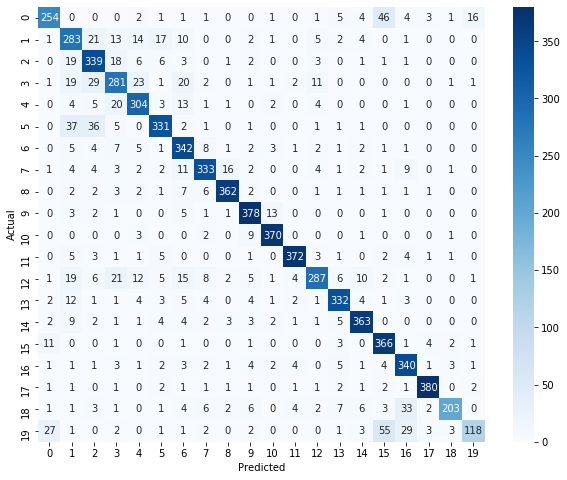

In [205]:
c_m = confusion_matrix(test_lem_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**3.2 Random Forest con TF + Stemming (Porter)**

Cross Validation (train set)

In [206]:
%%time
score = cross_val_score(clf, tf_train_stem_porter_x, train_stem_porter_y, cv=5)

CPU times: user 2min 25s, sys: 323 ms, total: 2min 25s
Wall time: 2min 25s


In [207]:
print(score)
print(score.mean())

[0.83200707 0.82316534 0.81999115 0.81291464 0.83104821]
0.8238252832893593


Previsione su dati mai visti (test set)

In [208]:
%%time
clf.fit(tf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       340
           1       0.67      0.80      0.73       374
           2       0.77      0.84      0.80       400
           3       0.72      0.73      0.72       393
           4       0.82      0.84      0.83       358
           5       0.84      0.83      0.84       416
           6       0.77      0.86      0.81       386
           7       0.88      0.86      0.87       396
           8       0.94      0.91      0.92       393
           9       0.90      0.93      0.91       405
          10       0.93      0.96      0.94       386
          11       0.94      0.94      0.94       400
          12       0.86      0.69      0.77       406
          13       0.88      0.86      0.87       380
          14       0.91      0.92      0.91       403
          15       0.74      0.94      0.83       391
          16       0.80      0.90      0.85       380
          17       0.96    

Confusion matrix

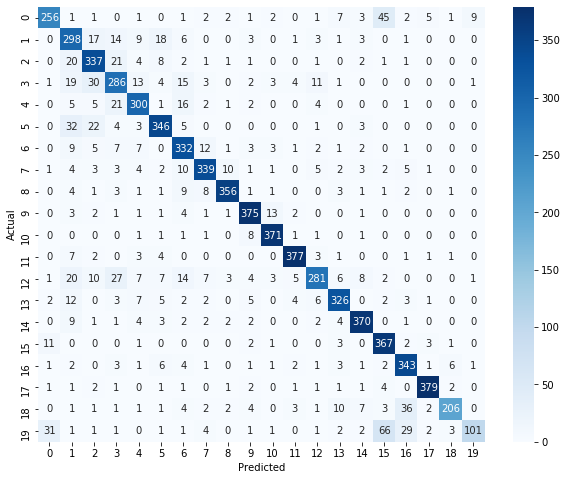

In [209]:
c_m = confusion_matrix(test_stem_porter_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**3.3 Random Forest con TF + Stemming (Snowball)**

Cross Validation (train set)

In [210]:
%%time
score = cross_val_score(clf, tf_train_stem_snowball_x, train_stem_snowball_y, cv=5)

CPU times: user 2min 25s, sys: 192 ms, total: 2min 25s
Wall time: 2min 25s


In [211]:
print(score)
print(score.mean())

[0.82714412 0.81211317 0.81910659 0.82176028 0.83016364]
0.8220575623799709


Previsione su dati mai visti (test set)

In [212]:
%%time
clf.fit(tf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       340
           1       0.67      0.79      0.72       374
           2       0.74      0.83      0.78       400
           3       0.75      0.72      0.74       393
           4       0.80      0.82      0.81       358
           5       0.87      0.80      0.84       416
           6       0.75      0.89      0.81       386
           7       0.87      0.86      0.87       396
           8       0.94      0.93      0.94       393
           9       0.88      0.93      0.91       405
          10       0.94      0.96      0.95       386
          11       0.95      0.94      0.94       400
          12       0.86      0.69      0.76       406
          13       0.90      0.88      0.89       380
          14       0.90      0.91      0.91       403
          15       0.75      0.93      0.83       391
          16       0.79      0.91      0.84       380
          17       0.96    

Confusion matrix

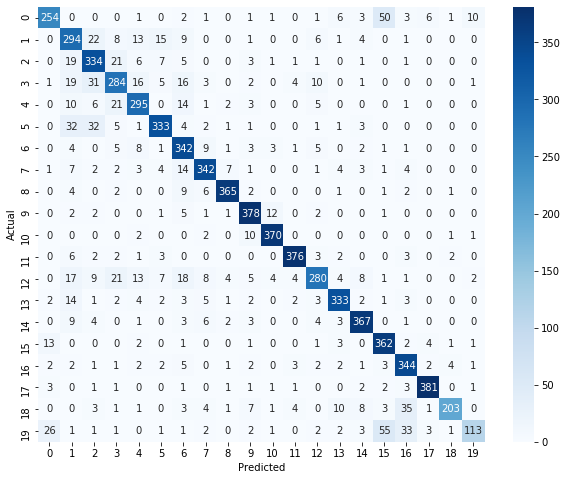

In [213]:
c_m = confusion_matrix(test_stem_snowball_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**3.4 Random Forest con TF + Stemming (Lancaster)**

Cross Validation (train set)

In [214]:
%%time
score = cross_val_score(clf, tf_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

CPU times: user 2min 15s, sys: 187 ms, total: 2min 15s
Wall time: 2min 16s


In [215]:
print(score)
print(score.mean())

[0.81697613 0.80548187 0.81247236 0.80672269 0.81866431]
0.812063471207274


Previsione su dati mai visti (test set)

In [216]:
%%time
clf.fit(tf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80       340
           1       0.66      0.79      0.72       374
           2       0.74      0.81      0.77       400
           3       0.72      0.71      0.72       393
           4       0.78      0.81      0.80       358
           5       0.85      0.77      0.81       416
           6       0.74      0.89      0.81       386
           7       0.87      0.86      0.87       396
           8       0.92      0.91      0.91       393
           9       0.89      0.93      0.91       405
          10       0.95      0.95      0.95       386
          11       0.94      0.94      0.94       400
          12       0.84      0.69      0.76       406
          13       0.89      0.86      0.87       380
          14       0.90      0.88      0.89       403
          15       0.74      0.93      0.83       391
          16       0.79      0.91      0.85       380
          17       0.95    

Confusion matrix

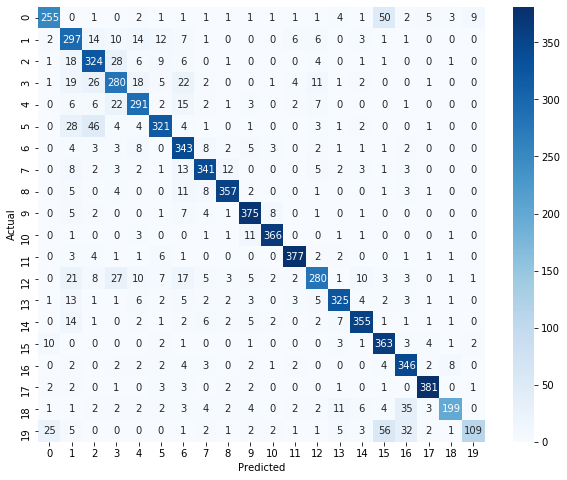

In [217]:
c_m = confusion_matrix(test_stem_lancaster_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**3.5 Random Forest con TF-IDF + Lemmatization**

Cross Validation (train set)

In [218]:
%%time
score = cross_val_score(clf, tfidf_train_lem_x, train_lem_y, cv=5)

CPU times: user 1min 31s, sys: 228 ms, total: 1min 31s
Wall time: 1min 31s


In [219]:
print(score)
print(score.mean())

[0.81962865 0.81697613 0.82352941 0.81158779 0.81291464]
0.8169273237704966


Previsione su dati mai visti (test set)

In [220]:
%%time
clf.fit(tfidf_train_lem_x, train_lem_y)
predicted = clf.predict(tfidf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.84      0.70      0.77       340
           1       0.66      0.77      0.71       374
           2       0.73      0.83      0.78       400
           3       0.76      0.70      0.73       393
           4       0.79      0.82      0.80       358
           5       0.84      0.79      0.81       416
           6       0.79      0.88      0.83       386
           7       0.84      0.83      0.84       396
           8       0.93      0.90      0.91       393
           9       0.87      0.92      0.89       405
          10       0.93      0.93      0.93       386
          11       0.93      0.92      0.93       400
          12       0.80      0.67      0.73       406
          13       0.84      0.87      0.86       380
          14       0.85      0.90      0.87       403
          15       0.74      0.92      0.82       391
          16       0.77      0.89      0.83       380
          17       0.96    

Confusion matrix

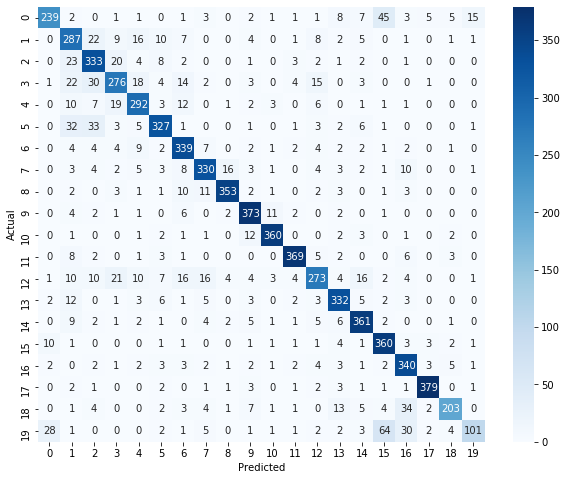

In [221]:
c_m = confusion_matrix(test_lem_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**3.6 Random Forest con TF-IDF + Stemming (Porter)**

Cross Validation (train set)

In [222]:
%%time
score = cross_val_score(clf, tfidf_train_stem_porter_x,train_stem_porter_y, cv=5)

CPU times: user 1min 33s, sys: 186 ms, total: 1min 33s
Wall time: 1min 33s


In [223]:
print(score)
print(score.mean())

[0.81211317 0.81078691 0.80362671 0.80318443 0.81203008]
0.808348261823227


Previsione su dati mai visti (test set)

In [224]:
%%time
clf.fit(tfidf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tfidf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       340
           1       0.62      0.74      0.68       374
           2       0.74      0.82      0.78       400
           3       0.73      0.72      0.72       393
           4       0.80      0.81      0.81       358
           5       0.83      0.79      0.81       416
           6       0.79      0.84      0.81       386
           7       0.87      0.84      0.85       396
           8       0.92      0.91      0.92       393
           9       0.89      0.91      0.90       405
          10       0.91      0.95      0.93       386
          11       0.94      0.93      0.94       400
          12       0.82      0.69      0.75       406
          13       0.83      0.88      0.85       380
          14       0.85      0.90      0.87       403
          15       0.74      0.92      0.82       391
          16       0.80      0.89      0.84       380
          17       0.94    

Confusion matrix

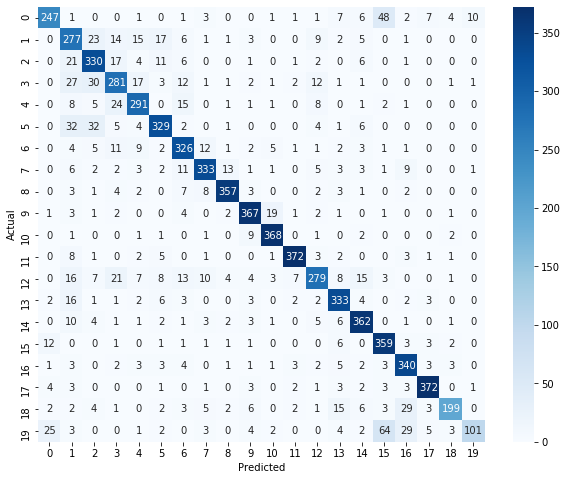

In [225]:
c_m = confusion_matrix(test_stem_porter_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**3.7 Random Forest con TF-IDF + Stemming (Snowball)**

Cross validation (train set)

In [226]:
%%time
score = cross_val_score(clf, tfidf_train_stem_snowball_x,train_stem_snowball_y, cv=5)

CPU times: user 1min 33s, sys: 221 ms, total: 1min 33s
Wall time: 1min 34s


In [227]:
print(score)
print(score.mean())

[0.81343943 0.80282935 0.8089341  0.80760725 0.81733746]
0.8100295206732699


Previsione su dati mai visti (test set)

In [228]:
%%time
clf.fit(tfidf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tfidf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       340
           1       0.66      0.78      0.72       374
           2       0.71      0.83      0.77       400
           3       0.75      0.73      0.74       393
           4       0.79      0.82      0.81       358
           5       0.83      0.78      0.80       416
           6       0.78      0.85      0.81       386
           7       0.87      0.82      0.84       396
           8       0.93      0.91      0.92       393
           9       0.91      0.91      0.91       405
          10       0.90      0.93      0.92       386
          11       0.95      0.93      0.94       400
          12       0.79      0.69      0.73       406
          13       0.84      0.88      0.86       380
          14       0.88      0.89      0.89       403
          15       0.73      0.92      0.81       391
          16       0.77      0.89      0.82       380
          17       0.96    

Confusion matrix

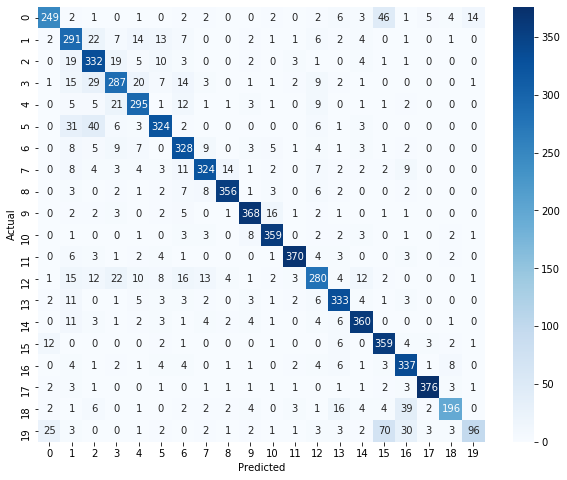

In [229]:
c_m = confusion_matrix(test_stem_snowball_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**3.8 Random Forest con TF-IDF + Stemming (Lancaster)**

Cross Validation (train set)

In [230]:
%%time
score = cross_val_score(clf, tfidf_train_stem_lancaster_x,train_stem_lancaster_y, cv=5)

CPU times: user 1min 40s, sys: 236 ms, total: 1min 40s
Wall time: 1min 40s


In [231]:
print(score)
print(score.mean())

[0.80150309 0.79354553 0.79478107 0.79920389 0.80362671]
0.798532061156167


Previsione su dati mai visti (test set)

In [232]:
%%time
clf.fit(tfidf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tfidf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.83      0.72      0.77       340
           1       0.65      0.75      0.70       374
           2       0.73      0.82      0.78       400
           3       0.70      0.72      0.71       393
           4       0.81      0.80      0.80       358
           5       0.82      0.78      0.80       416
           6       0.79      0.84      0.81       386
           7       0.81      0.80      0.80       396
           8       0.90      0.91      0.90       393
           9       0.88      0.90      0.89       405
          10       0.94      0.94      0.94       386
          11       0.94      0.91      0.93       400
          12       0.81      0.68      0.74       406
          13       0.84      0.87      0.85       380
          14       0.85      0.89      0.87       403
          15       0.73      0.91      0.81       391
          16       0.78      0.91      0.84       380
          17       0.95    

Confusion matrix

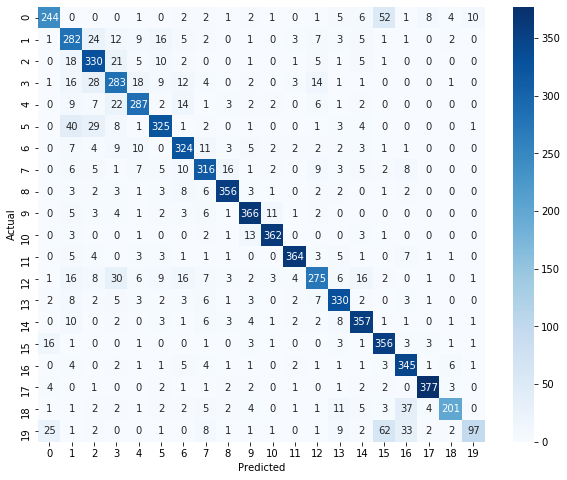

In [233]:
c_m = confusion_matrix(test_stem_lancaster_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**3.9 Random Forest con Bigram + Lemmatization**



Cross Validation (train set)

In [234]:
%%time
score = cross_val_score(clf, bi_train_lem_x, train_lem_y, cv=5)

CPU times: user 1min 31s, sys: 261 ms, total: 1min 31s
Wall time: 1min 31s


In [235]:
print(score)
print(score.mean())

[0.82007073 0.82051282 0.81822203 0.81777974 0.81556833]
0.8184307312203117


Previsione su dati mai visti (test set)

In [236]:
%%time
clf.fit(bi_train_lem_x, train_lem_y)
predicted = clf.predict(bi_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.88      0.73      0.80       340
           1       0.65      0.77      0.71       374
           2       0.73      0.84      0.78       400
           3       0.71      0.67      0.69       393
           4       0.76      0.81      0.78       358
           5       0.87      0.79      0.83       416
           6       0.80      0.87      0.83       386
           7       0.84      0.85      0.84       396
           8       0.92      0.88      0.90       393
           9       0.87      0.90      0.89       405
          10       0.91      0.93      0.92       386
          11       0.94      0.92      0.93       400
          12       0.79      0.67      0.73       406
          13       0.85      0.89      0.87       380
          14       0.89      0.89      0.89       403
          15       0.77      0.93      0.84       391
          16       0.79      0.89      0.84       380
          17       0.94    

Confusion matrix

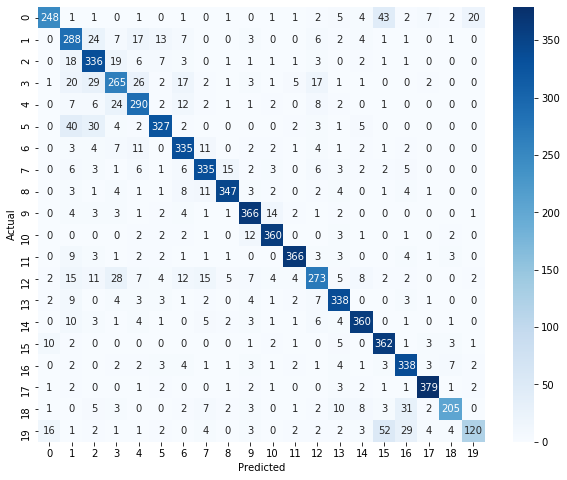

In [237]:
c_m = confusion_matrix(test_lem_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**3.10 Random Forest con Bigram + Stemming (Porter)**

Cross Validation (train set)

In [238]:
%%time
score = cross_val_score(clf, bi_train_stem_porter_x, train_stem_porter_y, cv=5)

CPU times: user 1min 31s, sys: 181 ms, total: 1min 31s
Wall time: 1min 31s


In [239]:
print(score)
print(score.mean())

[0.82007073 0.80946065 0.80804954 0.81999115 0.81158779]
0.8138319742248429


Previsione su dati mai visti (test set)

In [240]:
%%time
clf.fit(bi_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(bi_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80       340
           1       0.62      0.76      0.68       374
           2       0.76      0.82      0.79       400
           3       0.71      0.69      0.70       393
           4       0.78      0.81      0.79       358
           5       0.85      0.79      0.82       416
           6       0.79      0.86      0.82       386
           7       0.85      0.83      0.84       396
           8       0.92      0.90      0.91       393
           9       0.88      0.92      0.90       405
          10       0.92      0.94      0.93       386
          11       0.94      0.92      0.93       400
          12       0.81      0.67      0.74       406
          13       0.84      0.87      0.86       380
          14       0.87      0.89      0.88       403
          15       0.75      0.93      0.83       391
          16       0.79      0.89      0.84       380
          17       0.95    

Confusion matrix

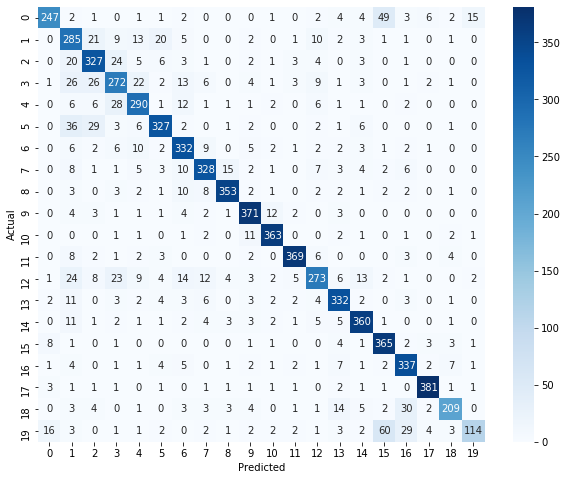

In [241]:
c_m = confusion_matrix(test_stem_porter_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**3.11 Random Forest con Bigram + Stemming (Snowball)**

Cross Validation (train set)

In [242]:
%%time
score = cross_val_score(clf, bi_train_stem_snowball_x, train_stem_snowball_y, cv=5)

CPU times: user 1min 30s, sys: 229 ms, total: 1min 31s
Wall time: 1min 31s


In [243]:
print(score)
print(score.mean())

[0.81830239 0.81034483 0.82308713 0.80760725 0.81601061]
0.8150704425285401


Previsione su dati mai visti (test set)

In [244]:
%%time
clf.fit(bi_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(bi_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.85      0.72      0.78       340
           1       0.64      0.79      0.71       374
           2       0.73      0.82      0.77       400
           3       0.74      0.69      0.72       393
           4       0.78      0.81      0.80       358
           5       0.87      0.76      0.81       416
           6       0.78      0.86      0.82       386
           7       0.86      0.83      0.85       396
           8       0.92      0.91      0.92       393
           9       0.88      0.92      0.90       405
          10       0.91      0.93      0.92       386
          11       0.94      0.92      0.93       400
          12       0.77      0.68      0.72       406
          13       0.86      0.87      0.86       380
          14       0.88      0.90      0.89       403
          15       0.76      0.94      0.84       391
          16       0.79      0.88      0.83       380
          17       0.95    

Confusion matrix

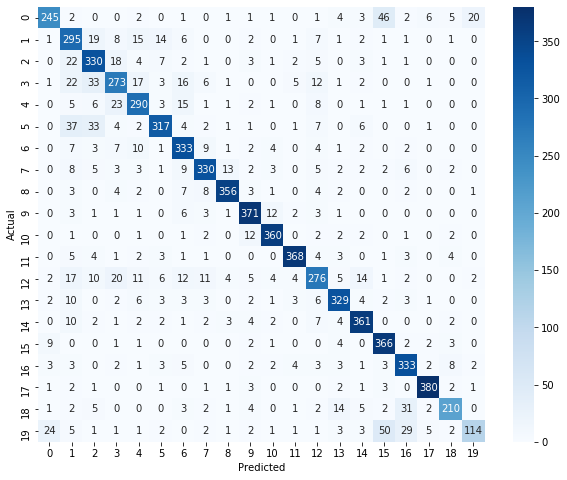

In [245]:
c_m = confusion_matrix(test_stem_snowball_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**3.12 Random Forest con Bigram + Stemming (Lancaster)**

Cross Validation (train set)

In [246]:
%%time
score = cross_val_score(clf, bi_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

CPU times: user 1min 33s, sys: 221 ms, total: 1min 33s
Wall time: 1min 33s


In [247]:
print(score)
print(score.mean())

[0.80857648 0.80017683 0.81335692 0.80672269 0.8137992 ]
0.8085264260667271


Previsione su dati mai visti (test set)

In [248]:
%%time
clf.fit(bi_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(bi_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.71      0.78       340
           1       0.64      0.77      0.70       374
           2       0.72      0.80      0.76       400
           3       0.68      0.69      0.69       393
           4       0.78      0.78      0.78       358
           5       0.85      0.76      0.80       416
           6       0.78      0.86      0.82       386
           7       0.86      0.81      0.83       396
           8       0.90      0.91      0.90       393
           9       0.85      0.89      0.87       405
          10       0.89      0.92      0.91       386
          11       0.95      0.92      0.93       400
          12       0.79      0.68      0.73       406
          13       0.83      0.86      0.85       380
          14       0.86      0.88      0.87       403
          15       0.74      0.92      0.82       391
          16       0.79      0.89      0.84       380
          17       0.96    

Confusion matrix

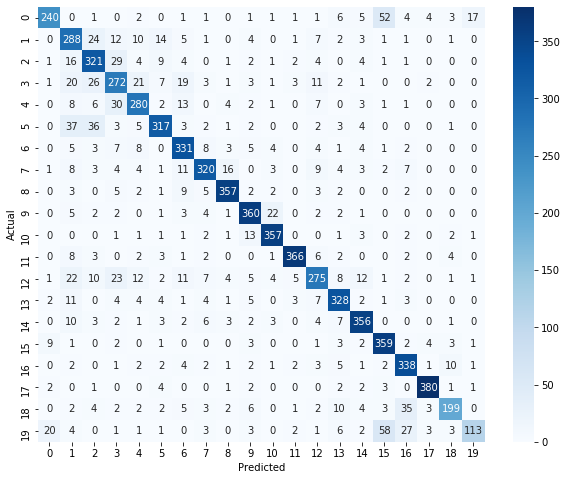

In [249]:
c_m = confusion_matrix(test_stem_lancaster_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

###**4. Xtereme Gradient Boosting (xgboost)**

In [0]:
clf= xgb.XGBClassifier()

**4.1 XGBOOST con TF + Lemmatization**

Cross Validation (train set)

In [252]:
%%time
score = cross_val_score(clf, tf_train_lem_x, train_lem_y, cv=5)

CPU times: user 15min 42s, sys: 596 ms, total: 15min 43s
Wall time: 15min 44s


In [253]:
print(score)
print(score.mean())

[0.79310345 0.7882405  0.79920389 0.79920389 0.80495356]
0.7969410575901448


Previsione su dati mai visti (test set)

In [254]:
%%time
clf.fit(tf_train_lem_x, train_lem_y)
predicted = clf.predict(tf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       340
           1       0.67      0.74      0.70       374
           2       0.70      0.78      0.74       400
           3       0.63      0.69      0.66       393
           4       0.80      0.79      0.79       358
           5       0.82      0.71      0.76       416
           6       0.80      0.83      0.82       386
           7       0.85      0.78      0.81       396
           8       0.92      0.87      0.89       393
           9       0.87      0.87      0.87       405
          10       0.94      0.86      0.90       386
          11       0.94      0.89      0.92       400
          12       0.57      0.70      0.63       406
          13       0.88      0.84      0.86       380
          14       0.85      0.86      0.86       403
          15       0.74      0.90      0.81       391
          16       0.78      0.83      0.81       380
          17       0.96    

Confusion matrix

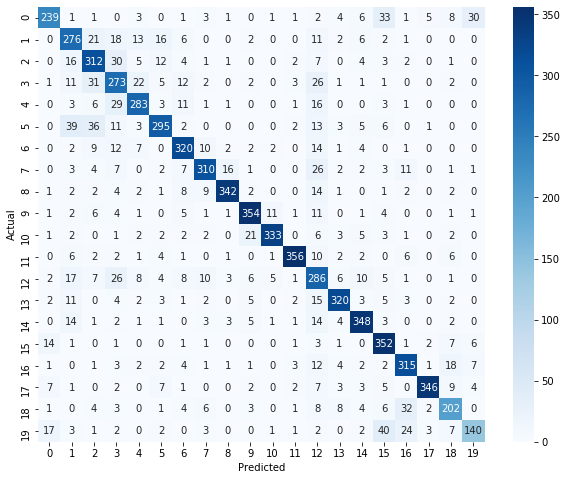

In [255]:
c_m = confusion_matrix(test_lem_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**4.2 XGBOOST con TF + Stemming (Porter)**

Cross Validation (train set)

In [256]:
%%time
score = cross_val_score(clf, tf_train_stem_porter_x, train_stem_porter_y, cv=5)

CPU times: user 13min 32s, sys: 336 ms, total: 13min 33s
Wall time: 13min 33s


In [257]:
print(score)
print(score.mean())

[0.79619805 0.78912467 0.79920389 0.80053074 0.80053074]
0.7971176185118749


Previsione su dati mai visti (test set)

In [258]:
%%time
clf.fit(tf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.82      0.72      0.76       340
           1       0.66      0.71      0.68       374
           2       0.69      0.77      0.72       400
           3       0.61      0.69      0.65       393
           4       0.80      0.78      0.79       358
           5       0.81      0.72      0.76       416
           6       0.79      0.81      0.80       386
           7       0.85      0.79      0.82       396
           8       0.91      0.88      0.90       393
           9       0.88      0.87      0.88       405
          10       0.94      0.87      0.90       386
          11       0.96      0.89      0.92       400
          12       0.58      0.69      0.63       406
          13       0.87      0.84      0.85       380
          14       0.86      0.85      0.85       403
          15       0.73      0.90      0.81       391
          16       0.80      0.81      0.80       380
          17       0.97    

Confusion matrix

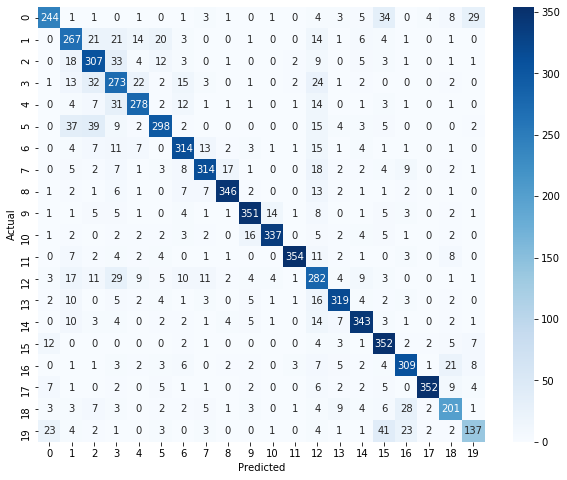

In [259]:
c_m = confusion_matrix(test_stem_porter_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**4.3 XGBOOST con TF + Stemming (Snowball)**

Cross Validation (train set)

In [260]:
%%time
score = cross_val_score(clf, tf_train_stem_snowball_x, train_stem_snowball_y, cv=5)

CPU times: user 13min 24s, sys: 321 ms, total: 13min 24s
Wall time: 13min 24s


In [261]:
print(score)
print(score.mean())

[0.79487179 0.78293546 0.79699248 0.79964617 0.79964617]
0.7948184159884811


Previsione su dati mai visti (test set)

In [262]:
%%time
clf.fit(tf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.83      0.72      0.77       340
           1       0.66      0.72      0.69       374
           2       0.68      0.77      0.72       400
           3       0.61      0.70      0.65       393
           4       0.79      0.77      0.78       358
           5       0.82      0.72      0.76       416
           6       0.79      0.82      0.80       386
           7       0.85      0.80      0.82       396
           8       0.92      0.89      0.90       393
           9       0.89      0.86      0.88       405
          10       0.93      0.88      0.90       386
          11       0.96      0.88      0.92       400
          12       0.56      0.69      0.62       406
          13       0.86      0.84      0.85       380
          14       0.86      0.86      0.86       403
          15       0.75      0.90      0.82       391
          16       0.80      0.81      0.81       380
          17       0.97    

Confusion matrix

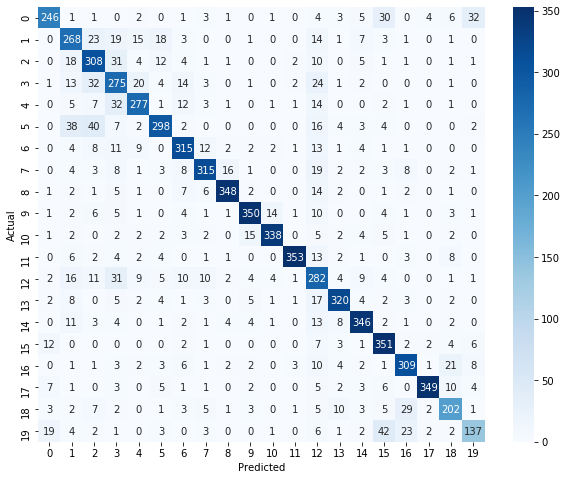

In [263]:
c_m = confusion_matrix(test_stem_snowball_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**4.4 XGBOOST con TF + Stemming (Lancaster)**

Cross Validation (train set)

In [264]:
%%time
score = cross_val_score(clf, tf_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

CPU times: user 12min 9s, sys: 314 ms, total: 12min 10s
Wall time: 12min 10s


In [265]:
print(score)
print(score.mean())

[0.78426172 0.77365164 0.78549314 0.78328173 0.79124281]
0.7835862084607681


Previsione su dati mai visti (test set)

In [266]:
%%time
clf.fit(tf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78       340
           1       0.65      0.72      0.68       374
           2       0.68      0.76      0.72       400
           3       0.63      0.69      0.66       393
           4       0.79      0.75      0.77       358
           5       0.79      0.72      0.75       416
           6       0.78      0.80      0.79       386
           7       0.82      0.78      0.80       396
           8       0.88      0.88      0.88       393
           9       0.87      0.85      0.86       405
          10       0.93      0.89      0.91       386
          11       0.95      0.91      0.93       400
          12       0.59      0.70      0.64       406
          13       0.84      0.83      0.84       380
          14       0.87      0.85      0.86       403
          15       0.74      0.87      0.80       391
          16       0.79      0.81      0.80       380
          17       0.95    

Confusion matrix

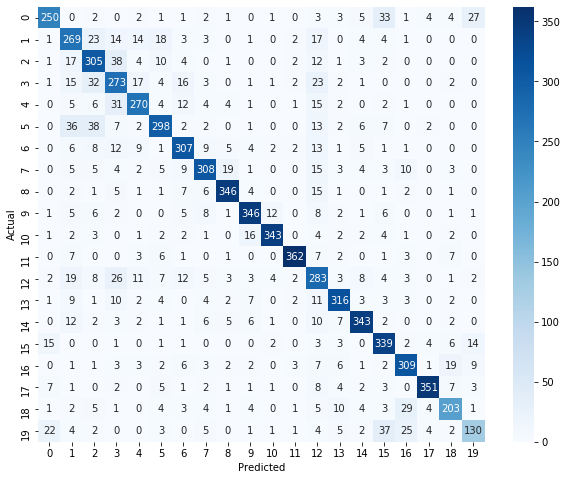

In [267]:
c_m = confusion_matrix(test_stem_lancaster_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**4.5 XGBOOST con TF-IDF + Lemmatization**

Cross Validation (train set)

In [268]:
%%time
score = cross_val_score(clf, tfidf_train_lem_x, train_lem_y, cv=5)

CPU times: user 13min 33s, sys: 311 ms, total: 13min 33s
Wall time: 13min 33s


In [269]:
print(score)
print(score.mean())

[0.79354553 0.78558798 0.79124281 0.78770456 0.7965502 ]
0.790926215523205


Previsione su dati mai visti (test set)

In [270]:
%%time
clf.fit(tfidf_train_lem_x, train_lem_y)
predicted = clf.predict(tfidf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       340
           1       0.67      0.74      0.70       374
           2       0.70      0.77      0.74       400
           3       0.63      0.71      0.67       393
           4       0.80      0.78      0.79       358
           5       0.80      0.72      0.76       416
           6       0.81      0.83      0.82       386
           7       0.85      0.80      0.82       396
           8       0.92      0.86      0.89       393
           9       0.86      0.86      0.86       405
          10       0.94      0.85      0.89       386
          11       0.94      0.89      0.91       400
          12       0.58      0.70      0.64       406
          13       0.86      0.84      0.85       380
          14       0.84      0.86      0.85       403
          15       0.73      0.90      0.81       391
          16       0.80      0.81      0.80       380
          17       0.95    

Confusion matrix

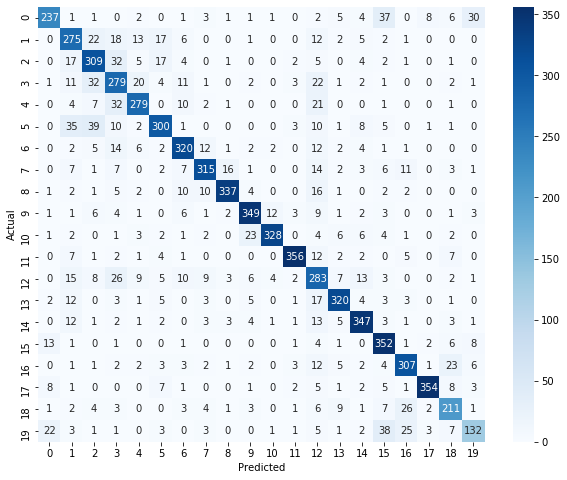

In [271]:
c_m = confusion_matrix(test_lem_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**4.6 XGBOOST con TF-IDF + Stemming (Porter)**

Cross Validation (train set)

In [272]:
%%time
score = cross_val_score(clf, tfidf_train_stem_porter_x, train_stem_porter_y, cv=5)

CPU times: user 13min 58s, sys: 321 ms, total: 13min 58s
Wall time: 13min 58s


In [273]:
print(score)
print(score.mean())

[0.79221927 0.78426172 0.78814684 0.79256966 0.79433879]
0.7903072551092195


Previsione su dati mai visti (test set)

In [274]:
%%time
clf.fit(tfidf_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(tfidf_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.82      0.70      0.75       340
           1       0.66      0.74      0.70       374
           2       0.70      0.76      0.73       400
           3       0.61      0.70      0.65       393
           4       0.80      0.77      0.78       358
           5       0.80      0.72      0.76       416
           6       0.79      0.81      0.80       386
           7       0.83      0.79      0.81       396
           8       0.92      0.86      0.89       393
           9       0.89      0.86      0.87       405
          10       0.93      0.88      0.90       386
          11       0.96      0.89      0.92       400
          12       0.58      0.70      0.64       406
          13       0.86      0.83      0.85       380
          14       0.85      0.85      0.85       403
          15       0.74      0.89      0.81       391
          16       0.77      0.80      0.79       380
          17       0.96    

Confusion matrix

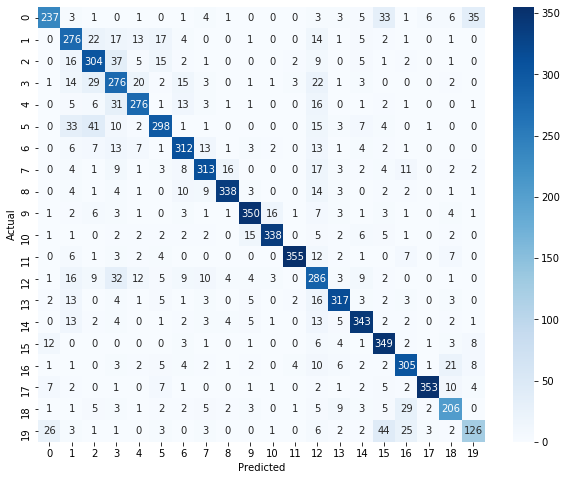

In [275]:
c_m = confusion_matrix(test_stem_porter_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**4.7 XGBOOST con TF-IDF + Stemming (Snowball)**



Cross Validation (train set)

In [276]:
%%time
score = cross_val_score(clf, tfidf_train_stem_snowball_x, train_stem_snowball_y, cv=5)

CPU times: user 14min 13s, sys: 315 ms, total: 14min 13s
Wall time: 14min 14s


In [277]:
print(score)
print(score.mean())

[0.79354553 0.78647215 0.78637771 0.78460858 0.79610792]
0.7894223779138907


Previsione su dati mai visti (test set)

In [278]:
%%time
clf.fit(tfidf_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(tfidf_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       340
           1       0.65      0.72      0.68       374
           2       0.70      0.77      0.73       400
           3       0.61      0.71      0.66       393
           4       0.81      0.79      0.80       358
           5       0.80      0.72      0.76       416
           6       0.79      0.81      0.80       386
           7       0.85      0.79      0.82       396
           8       0.92      0.86      0.89       393
           9       0.89      0.87      0.88       405
          10       0.93      0.88      0.90       386
          11       0.96      0.89      0.92       400
          12       0.59      0.69      0.64       406
          13       0.86      0.84      0.85       380
          14       0.85      0.85      0.85       403
          15       0.74      0.89      0.81       391
          16       0.77      0.80      0.79       380
          17       0.96    

Confusion matrix

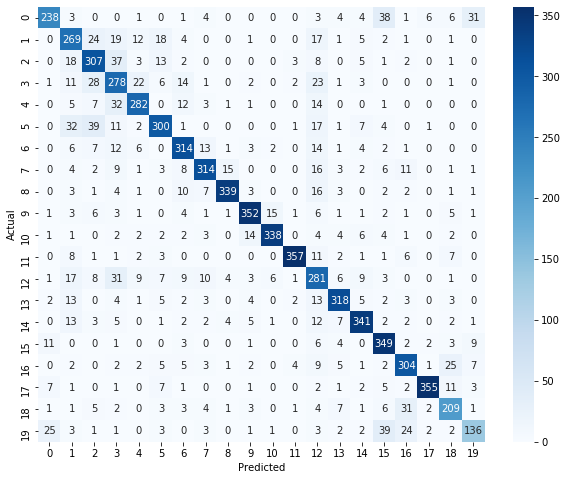

In [279]:
c_m = confusion_matrix(test_stem_snowball_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**4.8 XGBOOST con TF-IDF + Stemming (Lancaster)**

Cross Validation (train set)

In [280]:
%%time
score = cross_val_score(clf, tfidf_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

CPU times: user 14min 25s, sys: 349 ms, total: 14min 25s
Wall time: 14min 25s


In [281]:
print(score)
print(score.mean())

[0.78558798 0.77232538 0.77974348 0.78372402 0.77885891]
0.7800479510525415


Previsione su dati mai visti (test set)

In [282]:
%%time
clf.fit(tfidf_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(tfidf_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       340
           1       0.67      0.73      0.70       374
           2       0.69      0.75      0.72       400
           3       0.61      0.69      0.65       393
           4       0.76      0.76      0.76       358
           5       0.77      0.70      0.74       416
           6       0.78      0.79      0.78       386
           7       0.82      0.78      0.80       396
           8       0.90      0.88      0.89       393
           9       0.87      0.85      0.86       405
          10       0.92      0.88      0.90       386
          11       0.95      0.89      0.92       400
          12       0.59      0.69      0.64       406
          13       0.81      0.82      0.81       380
          14       0.85      0.86      0.86       403
          15       0.76      0.87      0.81       391
          16       0.78      0.80      0.79       380
          17       0.95    

Confusion matrix

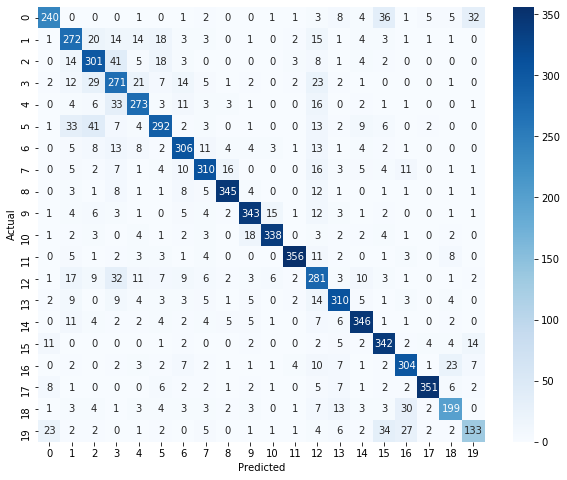

In [283]:
c_m = confusion_matrix(test_stem_lancaster_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**4.9 XGBOOST con Bigram + Lemmatization**

Cross Validation (train set)

In [284]:
%%time
score = cross_val_score(clf, bi_train_lem_x, train_lem_y, cv=5)

CPU times: user 15min 31s, sys: 424 ms, total: 15min 32s
Wall time: 15min 32s


In [285]:
print(score)
print(score.mean())

[0.79487179 0.79000884 0.79478107 0.79478107 0.80539584]
0.7959677239596104


Previsione su dati mai visti (test set)

In [286]:
%%time
clf.fit(bi_train_lem_x, train_lem_y)
predicted = clf.predict(bi_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.83      0.71      0.77       340
           1       0.69      0.73      0.71       374
           2       0.71      0.78      0.74       400
           3       0.64      0.71      0.67       393
           4       0.80      0.78      0.79       358
           5       0.84      0.76      0.80       416
           6       0.81      0.82      0.81       386
           7       0.84      0.80      0.82       396
           8       0.93      0.87      0.89       393
           9       0.88      0.87      0.88       405
          10       0.95      0.87      0.91       386
          11       0.94      0.89      0.91       400
          12       0.58      0.72      0.64       406
          13       0.87      0.84      0.85       380
          14       0.84      0.85      0.85       403
          15       0.75      0.91      0.82       391
          16       0.79      0.80      0.80       380
          17       0.95    

Confusion matrix

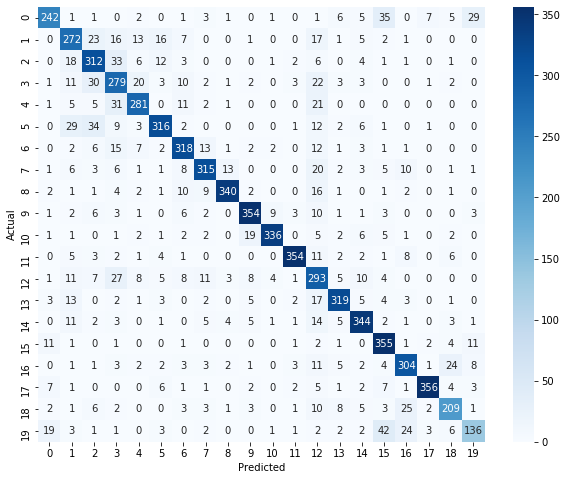

In [287]:
c_m = confusion_matrix(test_lem_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**4.10 XGBOOST con Bigram + Stemming (Porter)**

Cross Validation (train set)

In [288]:
%%time
score = cross_val_score(clf, bi_train_stem_porter_x, train_stem_porter_y, cv=5)

CPU times: user 15min 44s, sys: 370 ms, total: 15min 44s
Wall time: 15min 45s


In [289]:
print(score)
print(score.mean())

[0.79840849 0.78912467 0.79876161 0.79301194 0.80318443]
0.7964982279383902


Previsione su dati mai visti (test set)

In [290]:
%%time
clf.fit(bi_train_stem_porter_x, train_stem_porter_y)
predicted = clf.predict(bi_test_stem_porter_x)
print(classification_report(test_stem_porter_y, predicted))

              precision    recall  f1-score   support

           0       0.84      0.72      0.77       340
           1       0.66      0.74      0.70       374
           2       0.69      0.79      0.74       400
           3       0.63      0.69      0.66       393
           4       0.80      0.77      0.79       358
           5       0.85      0.76      0.80       416
           6       0.79      0.82      0.81       386
           7       0.84      0.79      0.81       396
           8       0.91      0.87      0.89       393
           9       0.89      0.87      0.88       405
          10       0.92      0.88      0.90       386
          11       0.96      0.89      0.92       400
          12       0.60      0.70      0.65       406
          13       0.86      0.84      0.85       380
          14       0.85      0.86      0.86       403
          15       0.76      0.91      0.83       391
          16       0.78      0.80      0.79       380
          17       0.96    

Confusion matrix

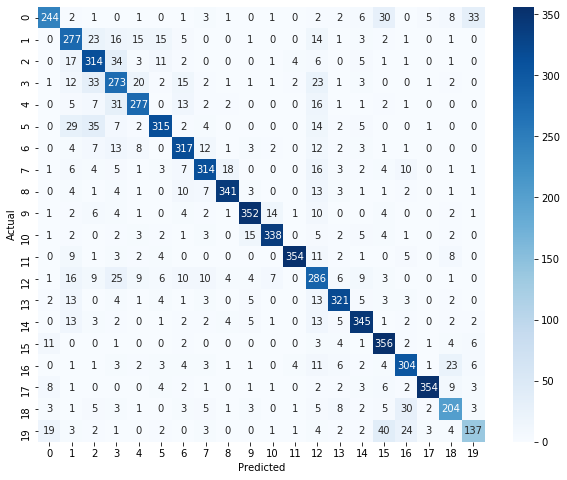

In [291]:
c_m = confusion_matrix(test_stem_porter_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**4.11 XGBOOST con Bigram + Stemming (Snowball)**

Cross Validation (train set)

In [292]:
%%time
score = cross_val_score(clf, bi_train_stem_snowball_x, train_stem_snowball_y, cv=5)

CPU times: user 15min 29s, sys: 314 ms, total: 15min 29s
Wall time: 15min 30s


In [293]:
print(score)
print(score.mean())

[0.80106101 0.79266136 0.79522335 0.79035825 0.79876161]
0.7956131161106073


Previsione su dati mai visti (test set)

In [294]:
%%time
clf.fit(bi_train_stem_snowball_x, train_stem_snowball_y)
predicted = clf.predict(bi_test_stem_snowball_x)
print(classification_report(test_stem_snowball_y, predicted))

              precision    recall  f1-score   support

           0       0.83      0.71      0.77       340
           1       0.67      0.74      0.70       374
           2       0.69      0.77      0.73       400
           3       0.63      0.72      0.67       393
           4       0.80      0.78      0.79       358
           5       0.85      0.75      0.80       416
           6       0.79      0.81      0.80       386
           7       0.82      0.79      0.80       396
           8       0.92      0.87      0.89       393
           9       0.89      0.87      0.88       405
          10       0.92      0.87      0.89       386
          11       0.96      0.89      0.92       400
          12       0.59      0.72      0.65       406
          13       0.87      0.84      0.86       380
          14       0.85      0.86      0.85       403
          15       0.76      0.90      0.82       391
          16       0.78      0.79      0.78       380
          17       0.96    

Confusion matrix

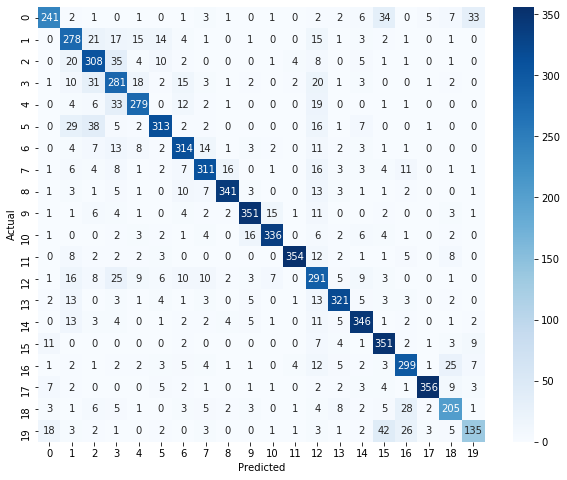

In [295]:
c_m = confusion_matrix(test_stem_snowball_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**4.12 XGBOOST con Bigram + Stemming (Lancaster)**

Cross Validation (train set)

In [296]:
%%time
score = cross_val_score(clf, bi_train_stem_lancaster_x, train_stem_lancaster_y, cv=5)

CPU times: user 15min 41s, sys: 374 ms, total: 15min 42s
Wall time: 15min 42s


In [297]:
print(score)
print(score.mean())

[0.7913351  0.77630416 0.78947368 0.78372402 0.79610792]
0.7873889748556129


Previsione su dati mai visti (test set)

In [298]:
%%time
clf.fit(bi_train_stem_lancaster_x, train_stem_lancaster_y)
predicted = clf.predict(bi_test_stem_lancaster_x)
print(classification_report(test_stem_lancaster_y, predicted))

              precision    recall  f1-score   support

           0       0.82      0.72      0.77       340
           1       0.68      0.74      0.71       374
           2       0.70      0.76      0.73       400
           3       0.63      0.70      0.66       393
           4       0.77      0.76      0.76       358
           5       0.81      0.74      0.77       416
           6       0.79      0.80      0.80       386
           7       0.81      0.77      0.79       396
           8       0.90      0.87      0.88       393
           9       0.87      0.86      0.87       405
          10       0.93      0.89      0.91       386
          11       0.94      0.90      0.92       400
          12       0.60      0.72      0.66       406
          13       0.81      0.84      0.82       380
          14       0.87      0.85      0.86       403
          15       0.77      0.88      0.82       391
          16       0.79      0.80      0.79       380
          17       0.94    

Confusion matrix

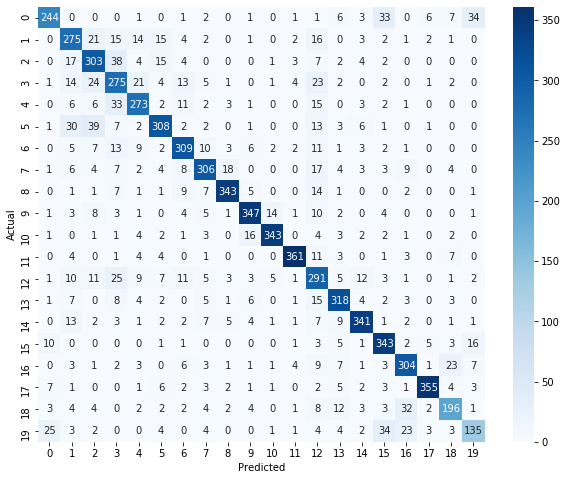

In [299]:
c_m = confusion_matrix(test_stem_lancaster_y, predicted)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(c_m, annot=True, cmap = "Blues", fmt ="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()